# Matching

Контакты для связи: Данила Солтык, Telegram: [t.me/Danspers](https://t.me/Danspers)

## Описание проекта

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад стали поступать новые партии товаров, которые имеет небольшие отличия в характеристиках. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые товары со старыми, пользуясь совпадающими характеристиками.

**Что надо сделать?**
- разработать алгоритм, который для всех товаров из _validation.csv_ предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике `accuracy@5`.

$$
accuracy@n = \frac{\text{кол-во верных соотношений (из n предложенных)}} {\text{общее кол-во объектов}} * 100\%
$$

Именно в _предложении 5 кандидатов_ для соотношения и заключается отличительная черта данной метрики.

**Данные:** [источник](https://disk.yandex.ru/d/BBEphK0EHSJ5Jw)

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный **id** (`0-base, 1-base, 2-base, …`) и вектор признаков размерностью 72.
- *train.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный **id** (`0-query, 1-query, …`) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный **id** и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

**План работы:**
- Загрузить данные
- Понять задачу
- Подготовить данные
- Обучить модель (поиск ближайших соседей + ранжирование top-5)
- Измерить качество
- git commit
- Сделать лучше!

[Notion](https://praktikum.notion.site/06a8d64f2b2e429d8738fff6e2bcf371)

___

## Подготовка

В библиотеке [Scikit-Learn](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors) существует метод поиска ближайших соседей, но весьма ресурсоёмкий из-за высокой точности вычислений. Поскольку исходный датасет имеет большой объём и абсолютная точность вычислений ближайших объектов не требуется, в этом проекте будет использована библиотека [Faiss](https://faiss.ai/index.html).

In [1]:
# импорт библиотек
import faiss
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler

Чтение датасетов, индексами в которых являются **id** товаров: `0-base, 1-base, 2-base, ... или 0-query, 1-query, ...`

In [2]:
base_df  = pd.read_csv('datasets/base.csv', index_col=0)
train_df = pd.read_csv('datasets/train.csv', index_col=0)
valid_df = pd.read_csv('datasets/validation.csv', index_col=0)
valid_ans_df = pd.read_csv('datasets/validation_answer.csv', index_col=0)

Необходимо привести к стандарту (змеиному_регистру) названия столбцов, а именно: избавиться от заглавных букв в названии.

In [ ]:
# задача на будущее


Для упрощения работы в следующей ячейке кода будет описана функция, которая выводит матрицу из графиков распределения значений всех колонок датасета. На вход она принимает один из исходных датасетов, и кол-во строк и столбцов в матрице. Для этих параметров уже заданы значения по-умолчанию, для вывода 72 графиков.

In [3]:
# Функция построения графиков распределения значений в колонках датасета (ver.3)

def show_graph_matrix(dataframe, color='blue', x=6, y=12):
    fig, axs = plt.subplots(y, x, figsize=(x*4, y*4))
    jx = 0 # накопитель
    for i in range(y):
        for j in range(x):
            column = str(i + j + jx)
            data = dataframe[column].value_counts().to_frame().reset_index().sort_values(by=column)
            axs[i, j].plot(column, 'count', data=data, marker='.', linestyle='', color=color)
            axs[i, j].set_title('Значения признака №' + column)
        jx += 5
    plt.show()

Для детального анализа конкретных колонок ниже описана функция, которая выводит top-5 популярных значений (и частоту их повторений), а так же графики распределения этих значений в разных масштабах (общий и увеличенный).

In [4]:
# Функция для подробного анализа значений колонки

def value_analysis(dataframe, column:str, ylim_max:float, color='blue'):
    print('Наиболее популярные значения')
    display((dataframe[column].value_counts(normalize=True)
                              .sort_values(ascending=False)*100)
                              .to_frame()
                              .rename(columns={column:'values','proportion':'frequency, %'})
                              .head())

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='.', linestyle='', color=color)
    axs[0].set_title('График распределения значений колонки №' + column + ' (общий вид)')
    axs[0].set_ylabel('Доля объектов от общего количества, %')
    axs[0].set_xlabel('Значения признака №' + column)
    axs[0].grid()

    axs[1].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='o', linestyle='', color=color)
    axs[1].set_title('График распределения значений колонки №' + column + ' (увеличенный вид)')
    axs[1].set_ylabel('Доля объектов от общего количества, %)')
    axs[1].set_xlabel('Значения признака №' + column)
    axs[1].set_ylim(0, ylim_max)
    axs[1].grid()
    plt.show()

Для удобного сравнения данны и их распределений из всех датасетов, ниже описана функция выводящая матрицу из графиков по аналогии с функцией `show_graph_matrix`

In [5]:
# Функция построения графиков распределения значений всех датасетов (ver.2)

def show_general_matrix(df_1, df_2, df_3, x=6, y=12):
    fig, axs = plt.subplots(y, x, figsize=(x*4, y*4))
    
    jx = 0 # накопитель
    for i in range(y):
        for j in range(x):
            column = str(i + j + jx)

            data_1 = df_1[column].value_counts(normalize=True).sort_index() * 100
            data_2 = df_2[column].value_counts(normalize=True).sort_index() * 100
            data_3 = df_3[column].value_counts(normalize=True).sort_index() * 100
            
            axs[i, j].plot(data_1, marker='o', linestyle='', color='lightblue')
            axs[i, j].plot(data_2, marker='+', linestyle='', color='red')
            axs[i, j].plot(data_3, marker='x', linestyle='', color='lightgreen')
            axs[i, j].set_title('Значения признака №' + column)
        jx += 5
    plt.show()

___

## Анализ данных

### Base

`Base` - набор из всех товаров (когда либо продававшихся на маркетплейсе) и 72 колонки с их характеристиками. Фактическое значение этих характеристик не имеет значения в рамках этого проекта. Эти данные прошли предварительную обработку (анонимизацию). По этой причине значения выглядят совершенно абстрактными на первый взгляд.

0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   

                 6          7           8           9  ...          62  \
Id                                                     ...               
0-base -469.070588  44.348083  120.915344  181.449700  ...  -42.808693   
1-base  -85.076666 -35.637436  119.718636  195.234190  ... -117.767525   
2-base   52.554795  62.381706  128.951450  164.381470  ...  -76.397800   
3-base -383.182845 -33.611237  122.031910  136.233580  ...  -70.647940   
4-base -397.711282  45.182500  122.167180  112.119064  ...  -57.199104   

               63         64          65        66         67          68  \
Id                                                                          
0-base  38.800827 -151.76218  -74.389090  63.66634  -4.703861   92.933610   
1-base  41.100000 -157.82940  -94.446806  68.20211  24.346846  179.937930   
2-base  46.011803 -207.14442  127.325570  65.56618  66.325680   81.073490   
3-base  -6.358921 -147.20105  -37.692750  66.20289 -20.566910  137.206940   
4-base  56.642403 -159.35184   85.944724  66.76632  -2.505783   65.315285   

                69           70         71  
Id                                          
0-base  115.269190  -112.756640 -60.830353  
1-base  116.834000   -84.888941 -59.524610  
2-base  116.594154 -1074.464888 -32.527206  
3-base  117.474100 -1074.464888 -72.915490  
4-base  135.051590 -1074.464888   0.319401  

[5 rows x 72 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   0       2918139 non-null  float64
 1   1       2918139 non-null  float64
 2   2       2918139 non-null  float64
 3   3       2918139 non-null  float64
 4   4       2918139 non-null  float64
 5   5       2918139 non-null  float64
 6   6       2918139 non-null  float64
 7   7       2918139 non-null  float64
 8   8       2918139 non-null  float64
 9   9       2918139 non-null  float64
 10  10      2918139 non-null  float64
 11  11      2918139 non-null  float64
 12  12      2918139 non-null  float64
 13  13      2918139 non-null  float64
 14  14      2918139 non-null  float64
 15  15      2918139 non-null  float64
 16  16      2918139 non-null  float64
 17  17      2918139 non-null  float64
 18  18      2918139 non-null  float64
 19  19      2918139 non-null  float64
 20  20      2918139 non

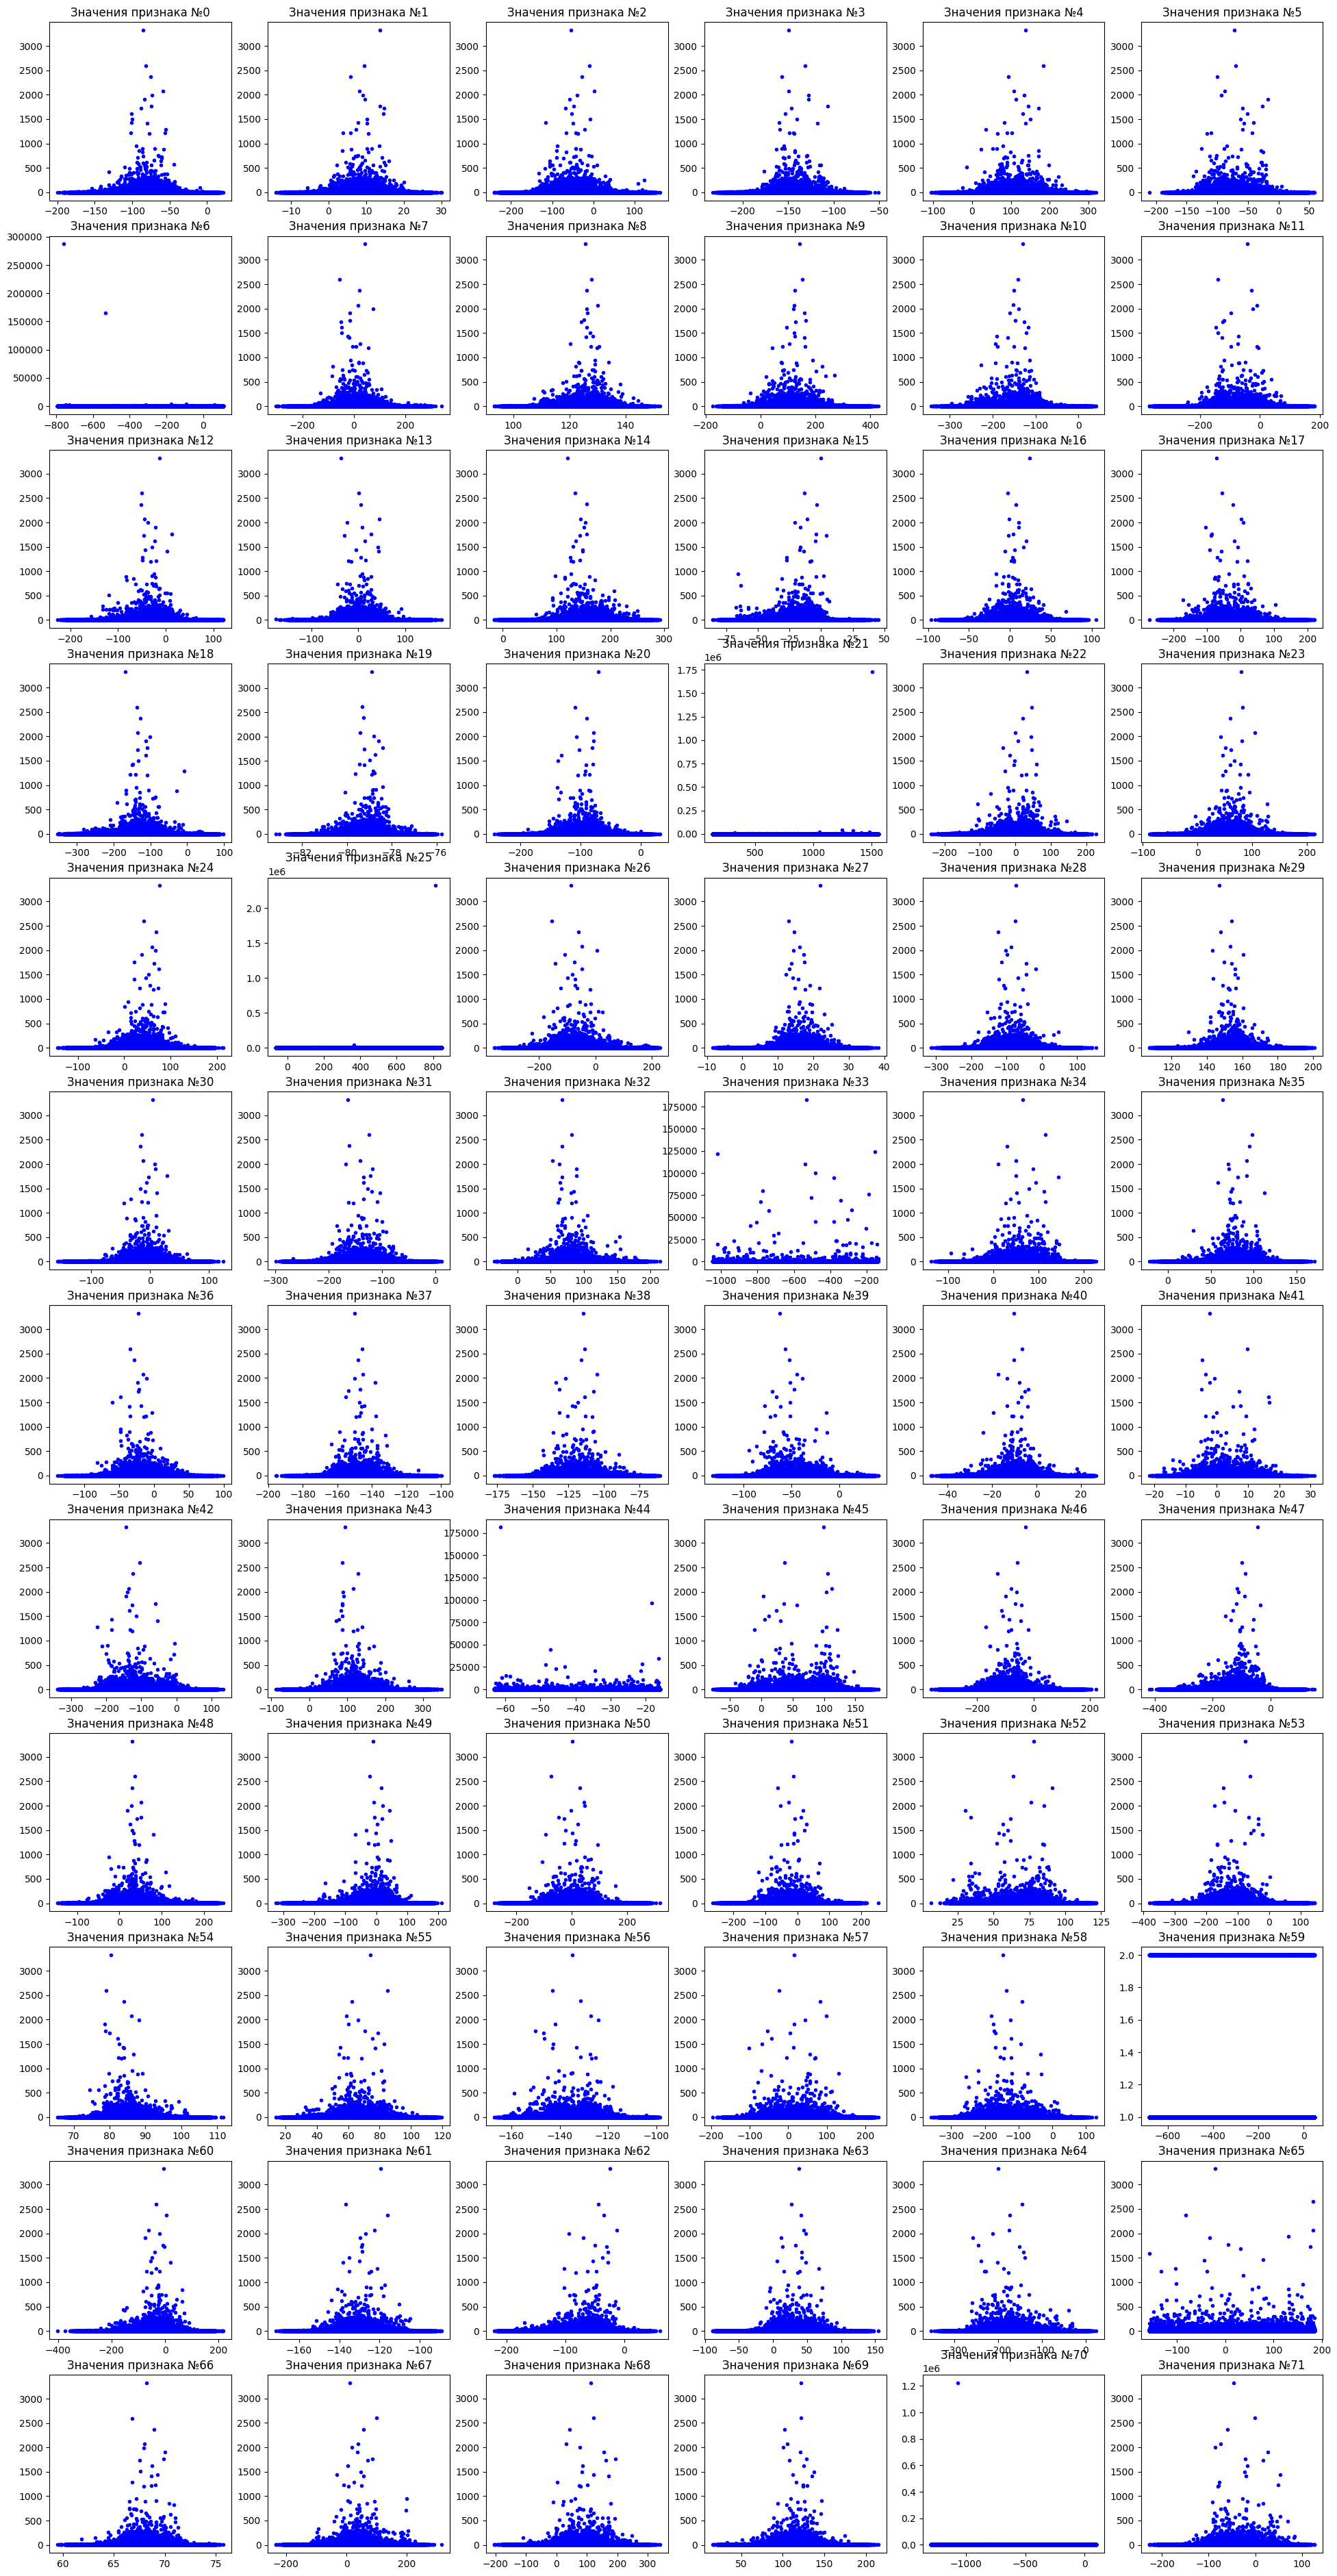

In [6]:
display(base_df.head())
print(base_df.info(verbose=True, show_counts=True))
print('Кол-во товаров-дубликатов:', base_df.duplicated().sum())
show_graph_matrix(base_df)

Большинство данных имеют вид _нормального распределения_ или очень схожего. В каждой колонке свой диапазон значений (широкий/узкий), встречаются как положительные та и отрицательные значения. Отдельное внимание стоит уделить столбцам №№ `6, 21, 25, 44, 45, 59, 65, 70`.

Наиболее популярные значения


frequency, %
6                        
-759.626065      9.838119
-530.124724      5.647949
-175.047853      0.127033
-92.055125       0.124120
-750.151074      0.091120

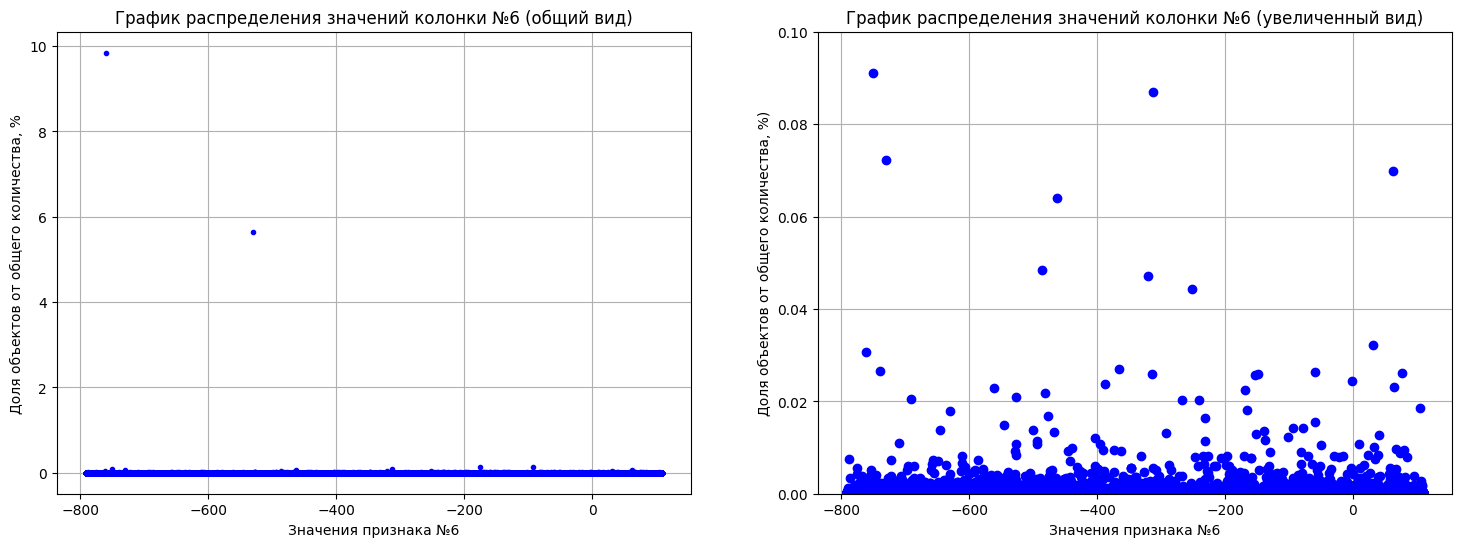

In [89]:
# распределение значений колонки №6
value_analysis(base_df, '6', 0.1)

Пара значений (-759.626065, -530.124724) особо выделяются. Они встречаются почти у 10% и 5% товаров, соответственно. Остальные значения не выделяются особой популярностью, и распределены равномерно на протяжении всего диапазона.

Наиболее популярные значения


frequency, %
21                       
1507.231274     59.214486
1248.126198      1.397603
1342.641120      1.128562
1483.714136      0.804828
1054.205600      0.683689

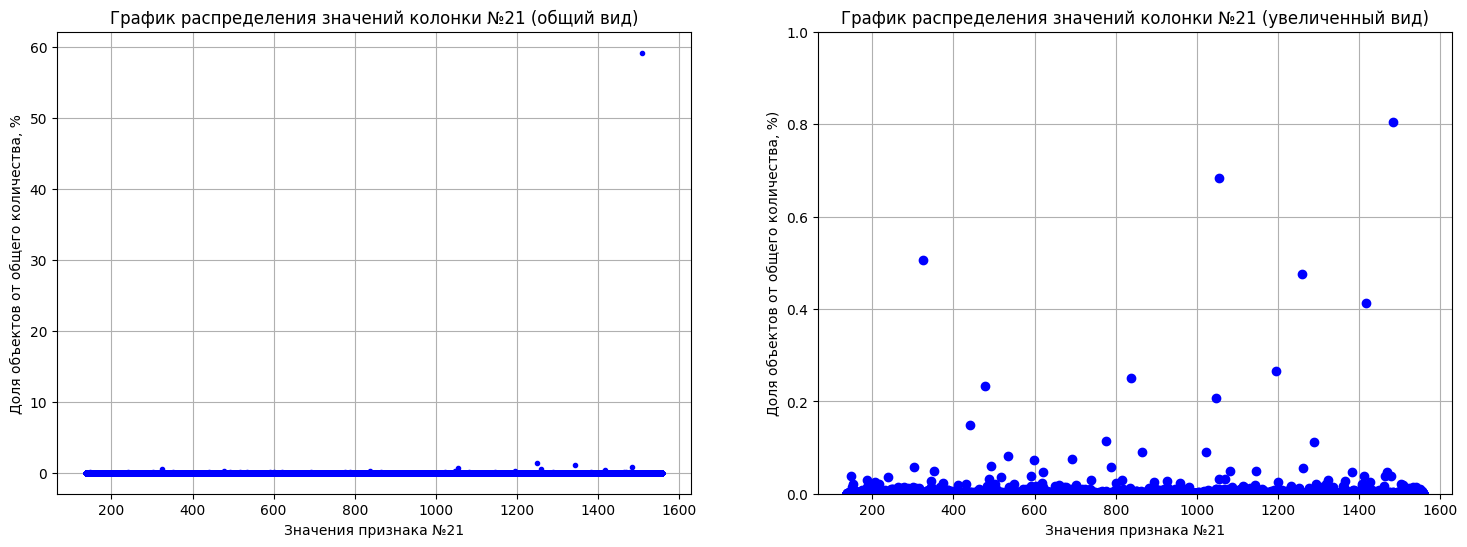

In [90]:
# распределение значений колонки №21
value_analysis(base_df, '21', 1)

Значений 1507.231274 особо популярно, встречается у ~60%. Остальные значения не популярны. Это отчётливо видно на графиках. В том числе их равномерное распределение на протяжении всего диапазона.

Наиболее популярные значения


frequency, %
25                      
813.770071     79.626776
366.779583      1.480670
175.595709      0.225658
514.955051      0.045543
701.226241      0.042150

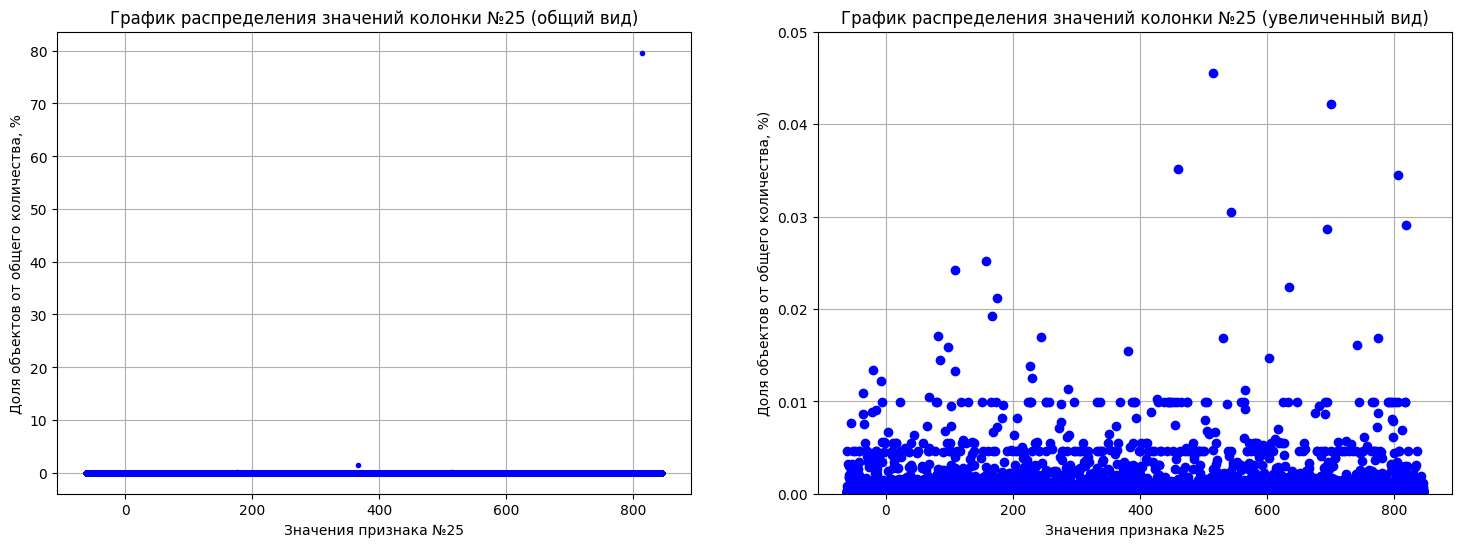

In [91]:
# распределение значений колонки №25
value_analysis(base_df, '25', 0.05)

Пара значений (813.770071, 813.770071) особо выделяются. Они встречаются почти у 80% и 1,5% товаров, соответственно. Остальные значения не выделяются особой популярностью, и распределены равномерно на протяжении всего диапазона. На увеличенном графике (справа) прослеживается явная закономерность. Некоторые значения встречаются с равной частотой. Возможно, это закодированный цвет товара.

Наиболее популярные значения


frequency, %
44                      
-61.441417      6.209197
-18.251750      3.321226
-47.166102      1.526212
-16.440254      1.192849
-21.092403      0.965958

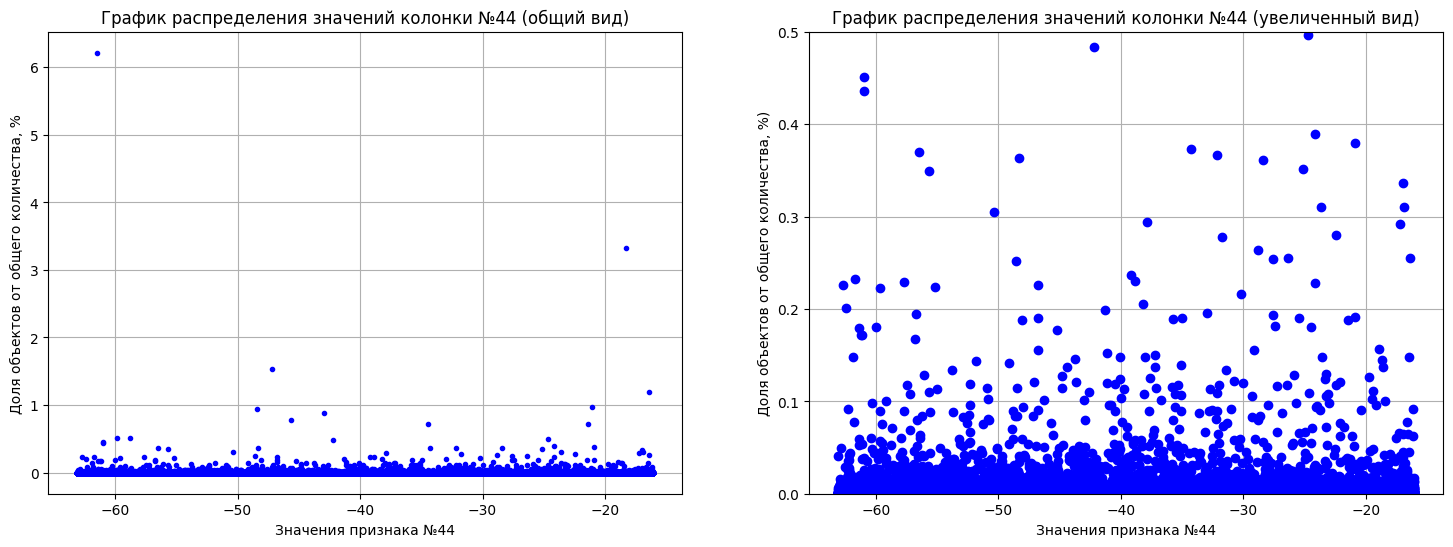

In [92]:
# распределение значений колонки №44
value_analysis(base_df, '44', 0.5)

Аналогичная ситуация. Пара популярных значений, а все остальные равномерно распределены по всему диапазону.

Значения встречающиеся в колонке №56: [   5.14971423 -251.95235755 -529.39695637 ... -509.1430963  -268.43850644
 -409.24383652] 

Соотношение товаров и уникальность значений их параметра №59
       кол-во товаров
count                
1             2913989
2                2075
Наиболее популярные значения


frequency, %
59                       
-230.403784      0.000069
-13.211805       0.000069
-82.038490       0.000069
-188.534014      0.000069
-651.846315      0.000069

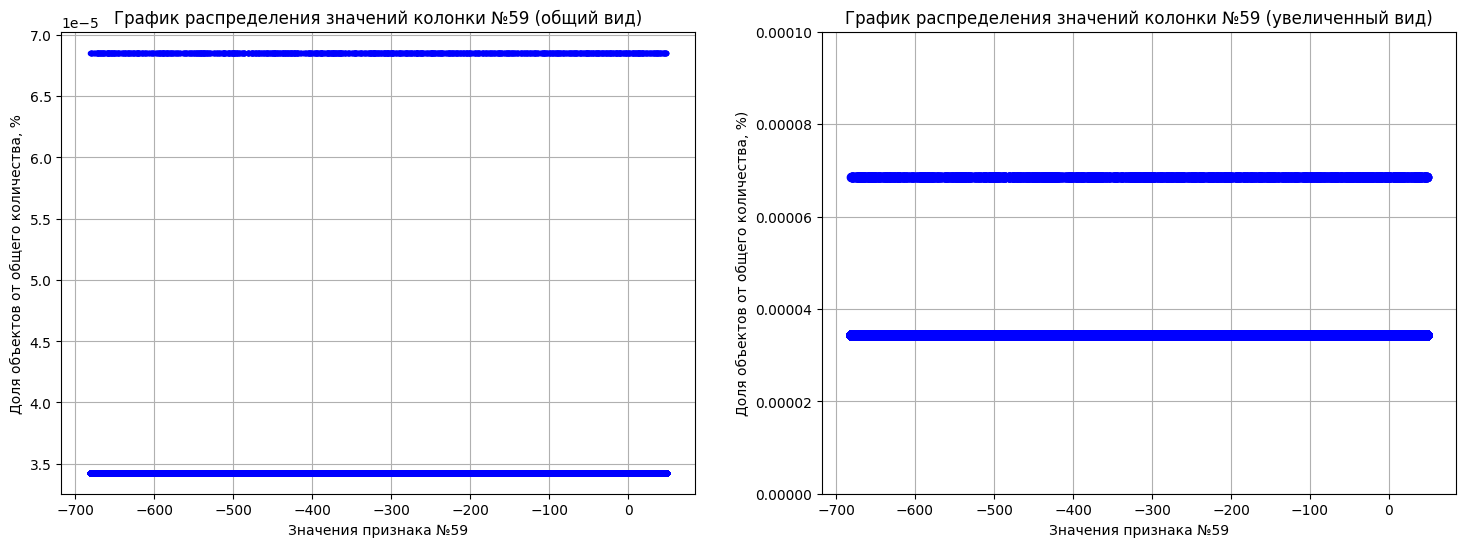

In [93]:
# анализ колонки №59
print('Значения встречающиеся в колонке №56:', base_df['59'].unique(), '\n')

print('Соотношение товаров и уникальность значений их параметра №59')
print(base_df['59'].value_counts().sort_values(ascending=False).value_counts().to_frame().rename(columns={'count':'кол-во товаров'}))

value_analysis(base_df, '59', 0.0001)

Почти у каждого товара этот параметр уникальный и не повторяется. В от 2075 товаров, которые заимствуют этот параметр от другого товара.

Наиболее популярные значения


frequency, %
65                       
-21.533007       0.113703
 181.959582      0.091085
-81.475771       0.081113
 182.446349      0.070696
 130.450168      0.066207

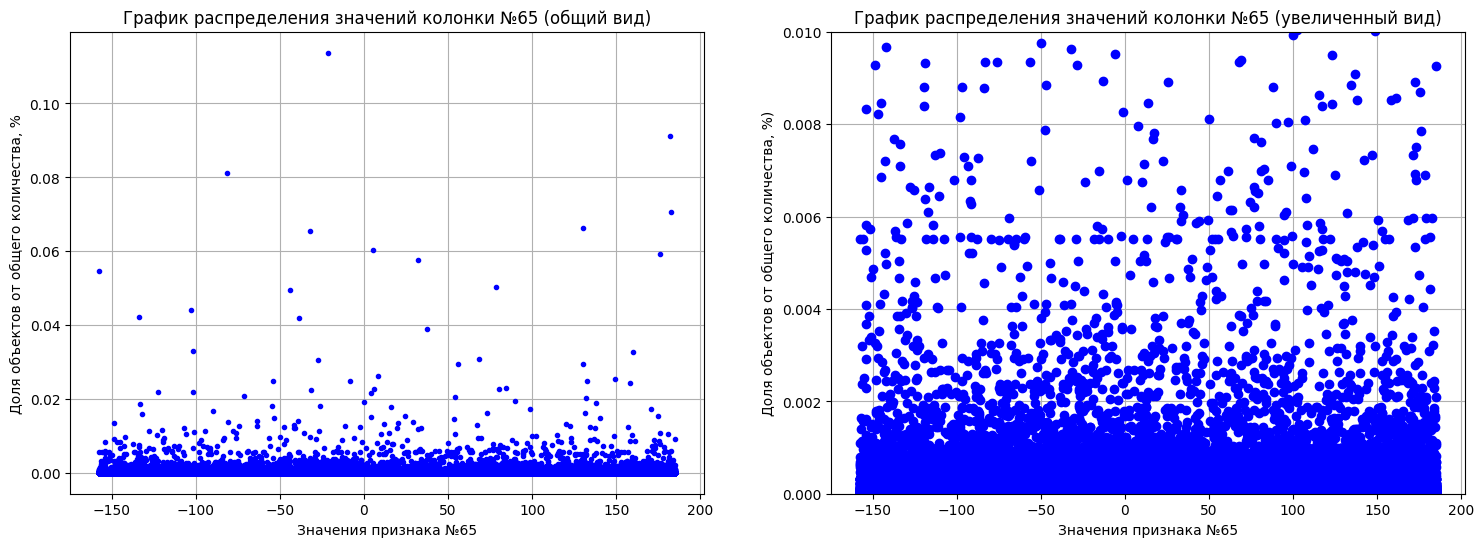

In [94]:
# распределение значений колонки №65
value_analysis(base_df, '65', 0.01)

Равномерное распределение значений, за редкими исключениями определённых значений.

Наиболее популярные значения


frequency, %
70                        
-1074.464888     41.923877
-782.676180       0.235321
-597.491204       0.028957
-799.363667       0.005106
-891.219087       0.005072

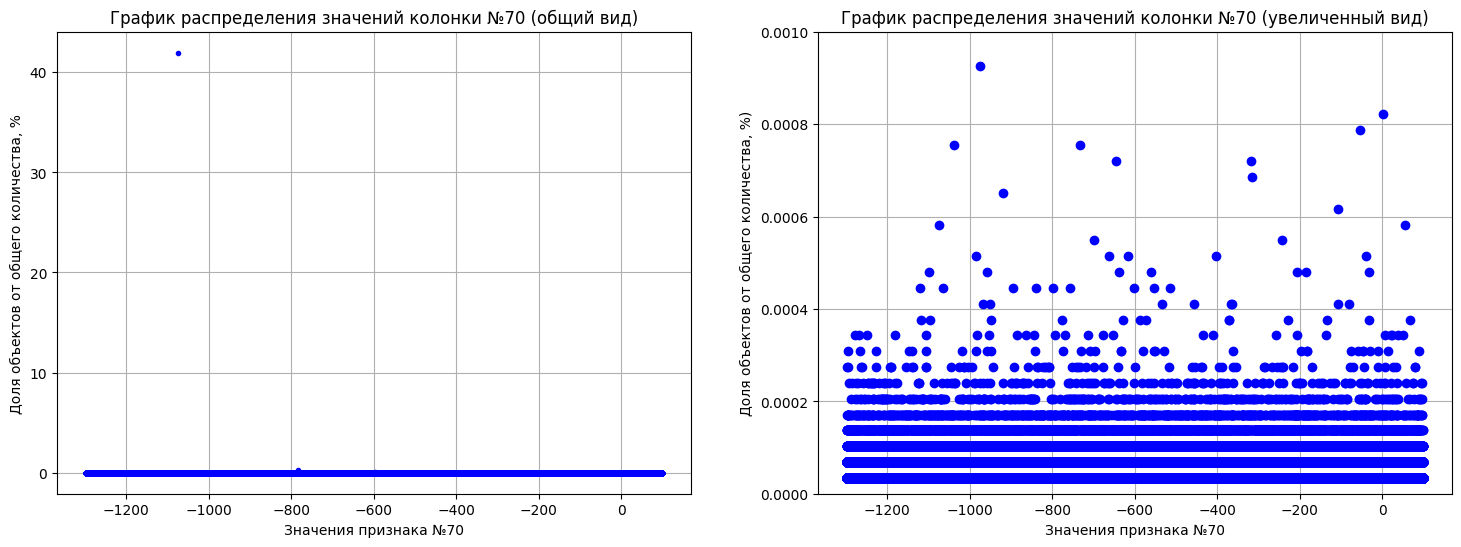

In [95]:
# распределение значений колонки №70
value_analysis(base_df, '70', 0.001)

Особо популярное значение (-1074.464888) встречающее более чем у 40% товаров. Остальные значения распределены равномерно на протяжении всего диапазона. На увеличенном графике (справа) прослеживается явная дискретность частоты повторения значений.

Общий вывод по данным: значения распределены равномерно. Выбросы отсутствуют.

### Train

`Train` - набор из товаров новых поставок, для которых известны соответствующие товары из "старого" датасета base. ID этого товара содержится в отдельном датасете target.

0          1           2          3           4           5  \
Id                                                                             
0-query -53.882748  17.971436  -42.117104 -183.93668  187.517490  -87.144930   
1-query -87.776370   6.806268  -32.054546 -177.26039  120.803330  -83.810590   
2-query -49.979565   3.841486 -116.118590 -180.40198  190.128430  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.01136   94.652840 -109.255410   
4-query -79.632126  14.442886  -58.903397 -147.05254   57.127068  -16.239529   

                  6          7           8           9  ...         63  \
Id                                                      ...              
0-query -347.360606  38.307602  109.085560   30.413513  ...  70.107360   
1-query  -94.572749 -78.433090  124.915900  140.331070  ...   4.669178   
2-query   26.943937 -30.447489  125.771164  211.607820  ...  78.039764   
3-query -775.150134  79.186520  124.003100  242.650650  ...  44.515266   
4-query -321.317964  45.984676  125.941284  103.392670  ...  45.028910   

                64          65         66          67          68          69  \
Id                                                                              
0-query -155.80257 -101.965943  65.903790   34.457500   62.642094  134.763600   
1-query -151.69771   -1.638704  68.170876   25.096191   89.974976  130.589630   
2-query -169.14620   82.144186  66.008220   18.400496  212.409730  121.931470   
3-query -145.41675   93.990981  64.131350  106.061920   83.178760  118.277725   
4-query -196.09207 -117.626337  66.926220   42.456170   77.621765   92.479930   

                  70         71        Target  
Id                                             
0-query  -415.750254 -25.958572   675816-base  
1-query -1035.092211 -51.276833   366656-base  
2-query -1074.464888 -22.547178  1447819-base  
3-query -1074.464888 -19.902788  1472602-base  
4-query -1074.464888 -21.149351   717819-base  

[5 rows x 73 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

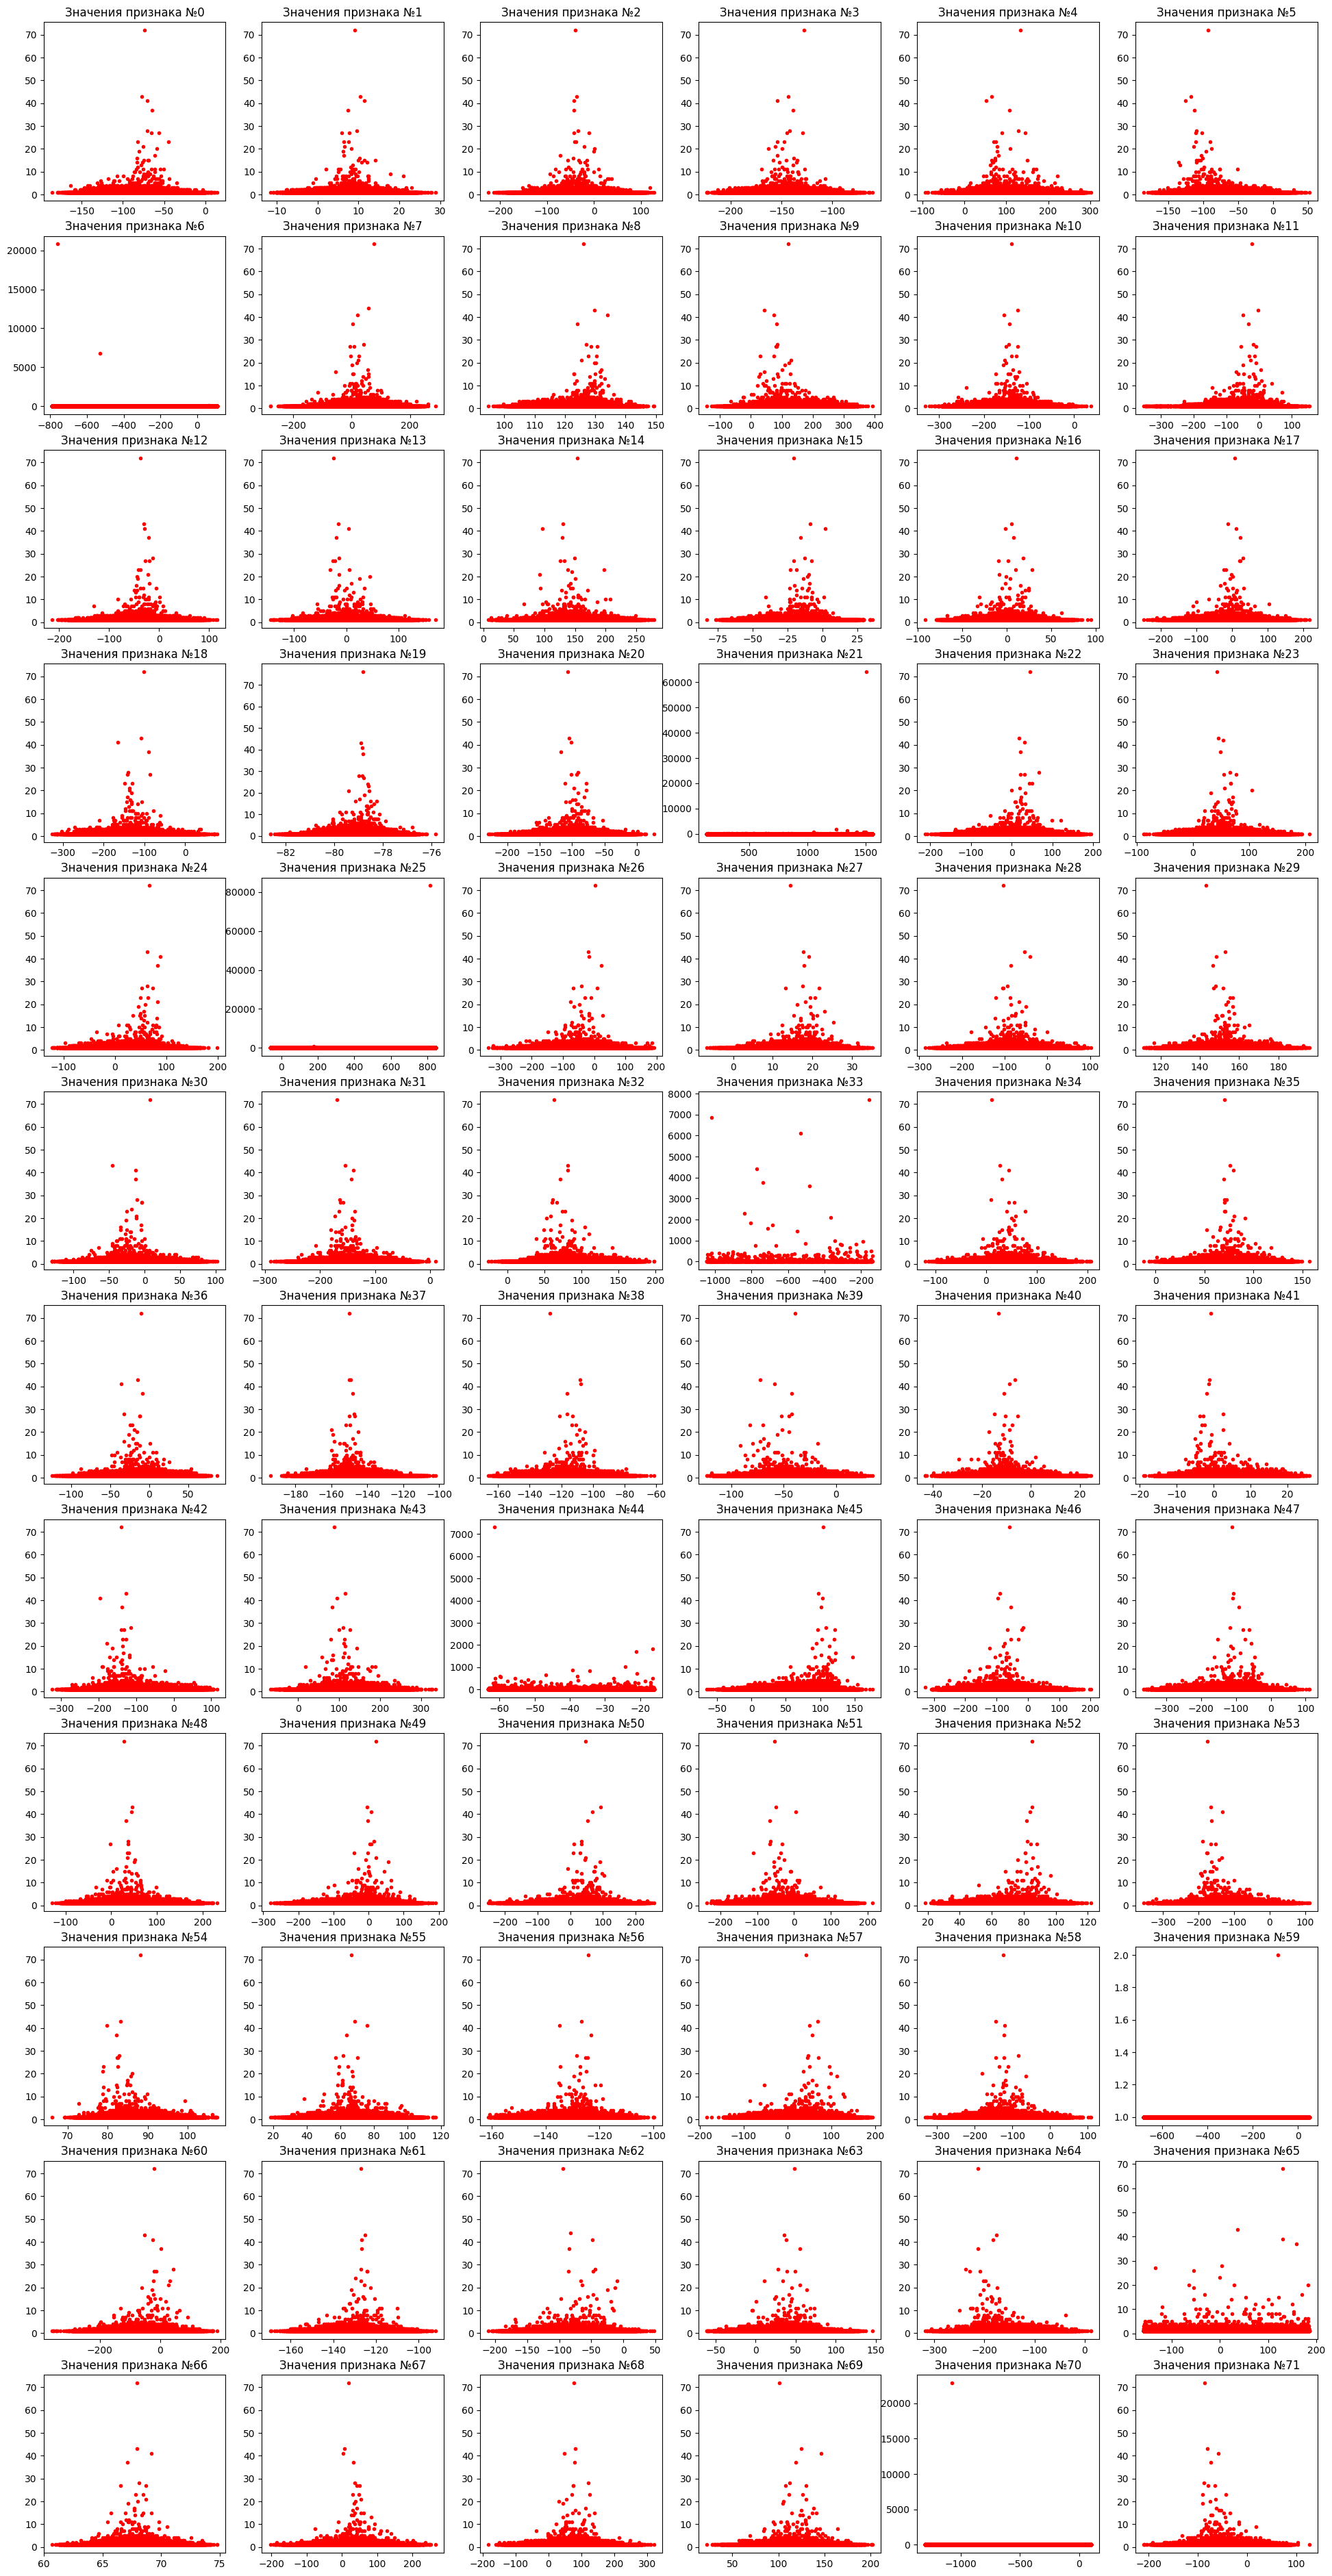

In [96]:
display(train_df.head())
train_df.info()
print('Кол-во товаров-дубликатов:', train_df.duplicated().sum())
show_graph_matrix(train_df, color='red')

Тренировочные данные имеют аналогичный вид как в base.csv. Значения параметров №№ `6, 21, 25, 44, 45, 59, 65, 70` распределены равномерно на всём диапазоне. Встречаются особо популярные значения. Большинство данных имеют вид _нормального распределения_ или очень схожего.

Наиболее популярные значения


frequency, %
6                        
-759.626065      9.838119
-530.124724      5.647949
-175.047853      0.127033
-92.055125       0.124120
-750.151074      0.091120

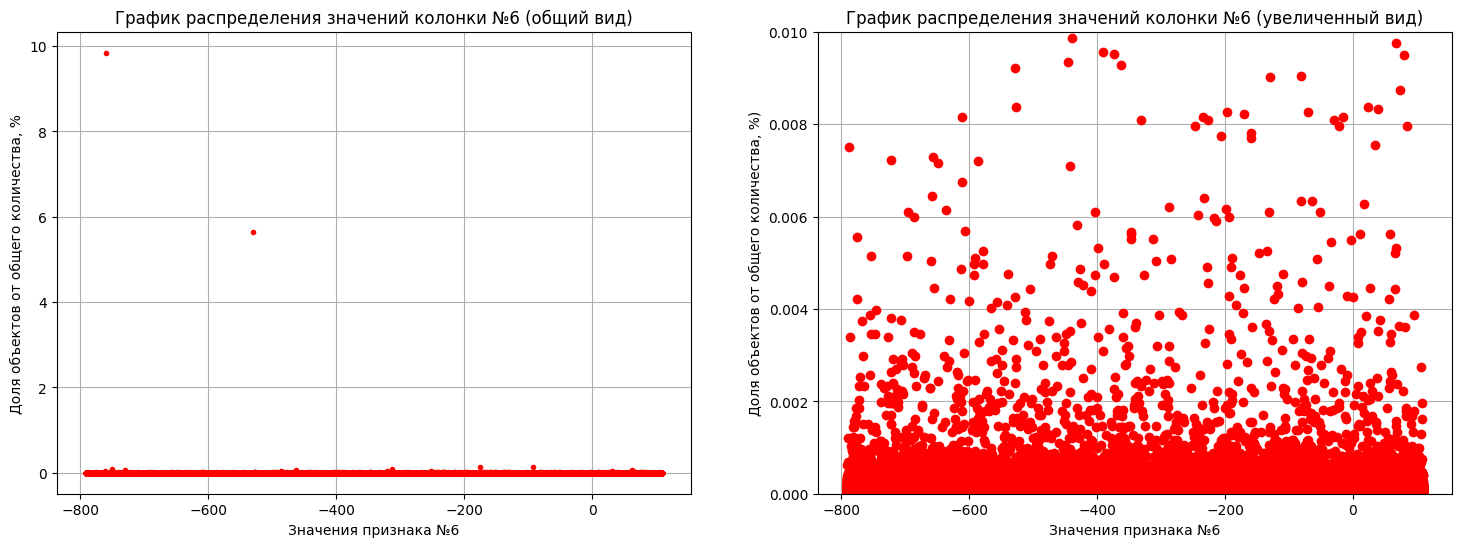

In [97]:
# распределение значений колонки №6
value_analysis(train_df, '6', 0.01, 'red')

Наиболее популярные значения


frequency, %
21                       
1507.231274     59.214486
1248.126198      1.397603
1342.641120      1.128562
1483.714136      0.804828
1054.205600      0.683689

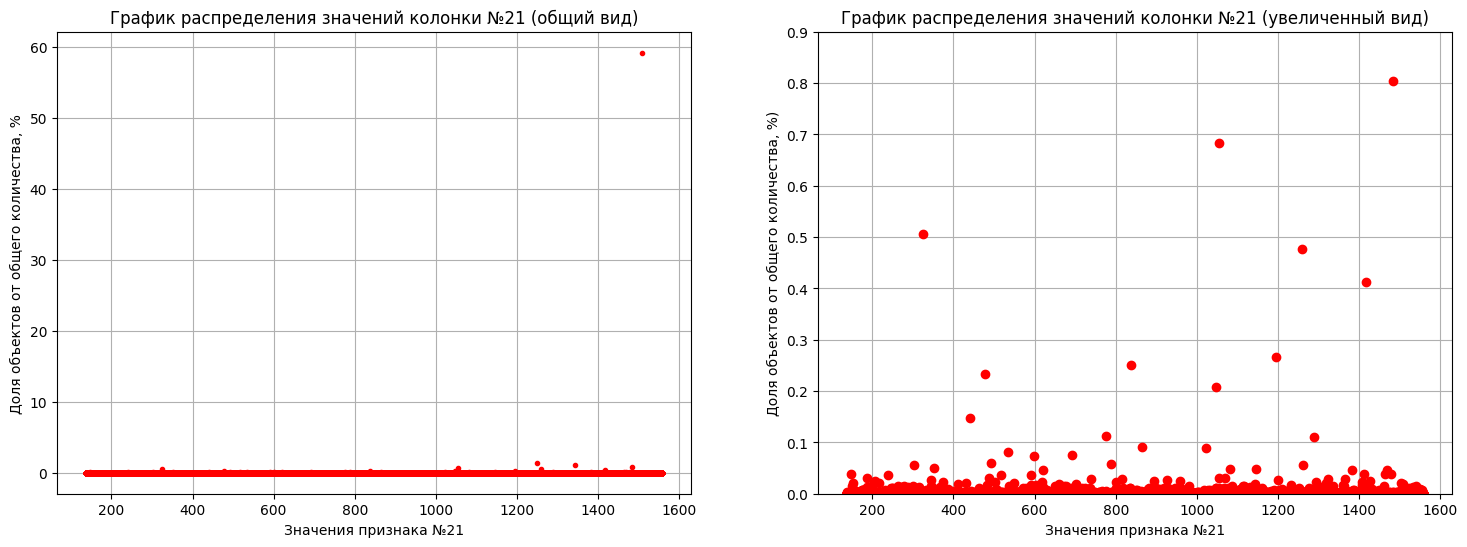

In [98]:
# распределение значений колонки №21
value_analysis(train_df, '21', 0.9, 'red')

Наиболее популярные значения


frequency, %
25                      
813.770071     79.626776
366.779583      1.480670
175.595709      0.225658
514.955051      0.045543
701.226241      0.042150

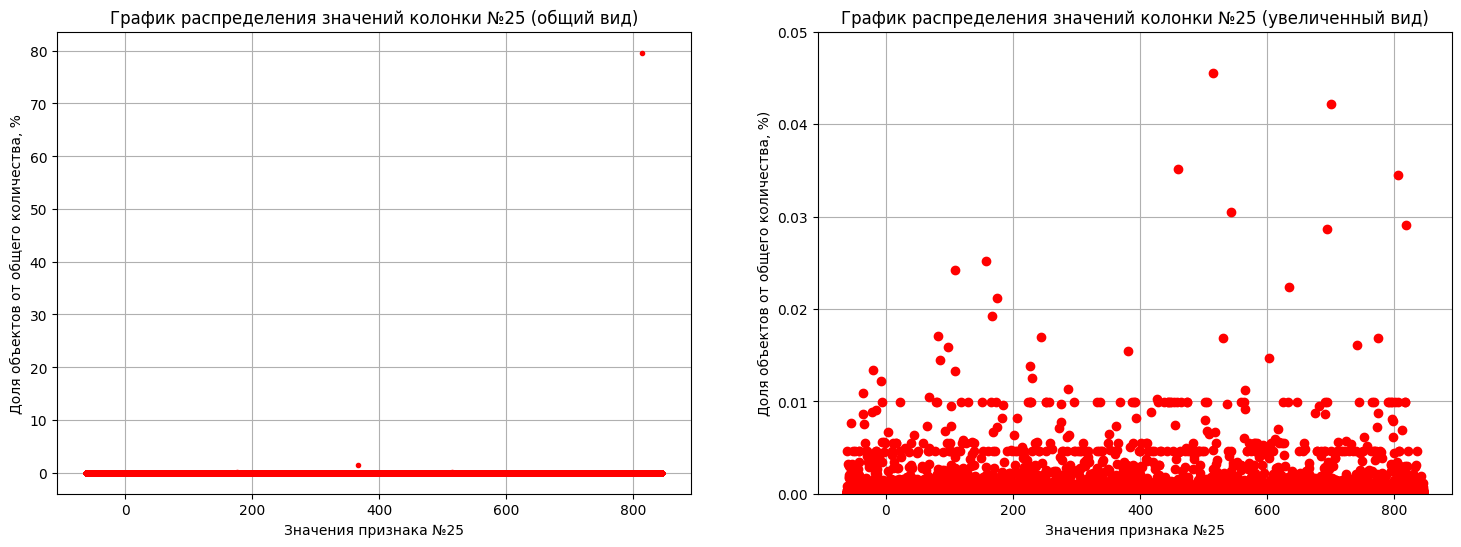

In [99]:
# распределение значений колонки №25
value_analysis(train_df, '25', 0.05, 'red')

Наиболее популярные значения


frequency, %
44                      
-61.441417      6.209197
-18.251750      3.321226
-47.166102      1.526212
-16.440254      1.192849
-21.092403      0.965958

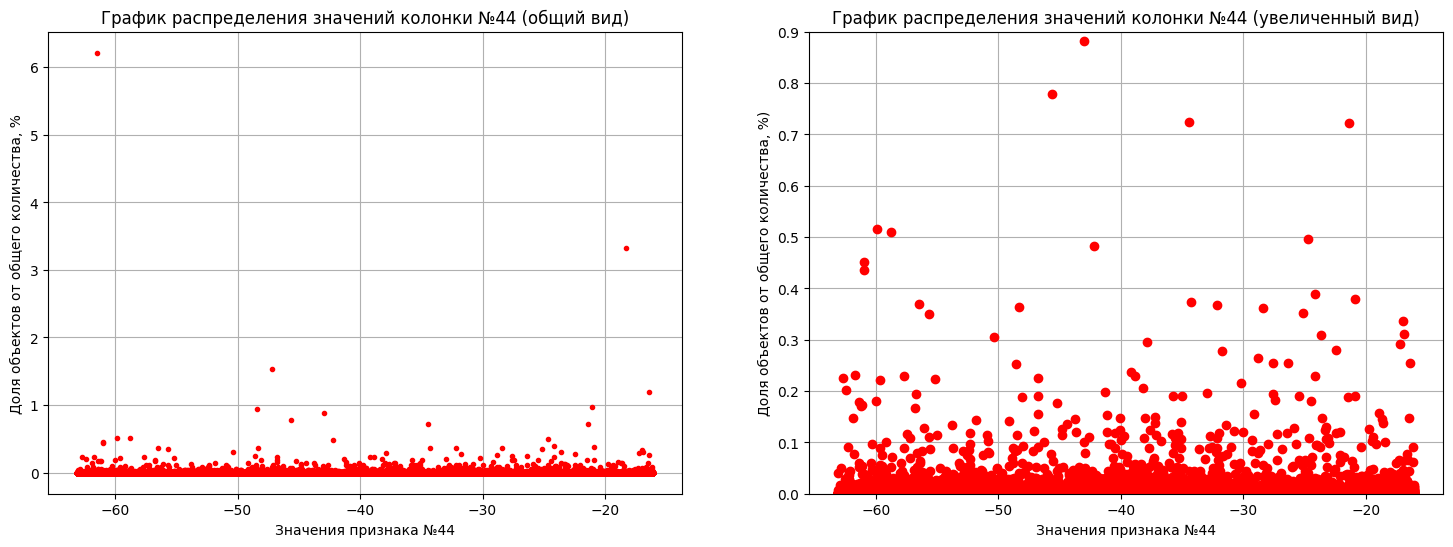

In [100]:
# распределение значений колонки №44
value_analysis(train_df, '44', 0.9, 'red')

Наиболее популярные значения


frequency, %
45                      
99.057945       0.113840
37.765175       0.089064
106.433525      0.081250
113.029050      0.071004
103.809310      0.068331

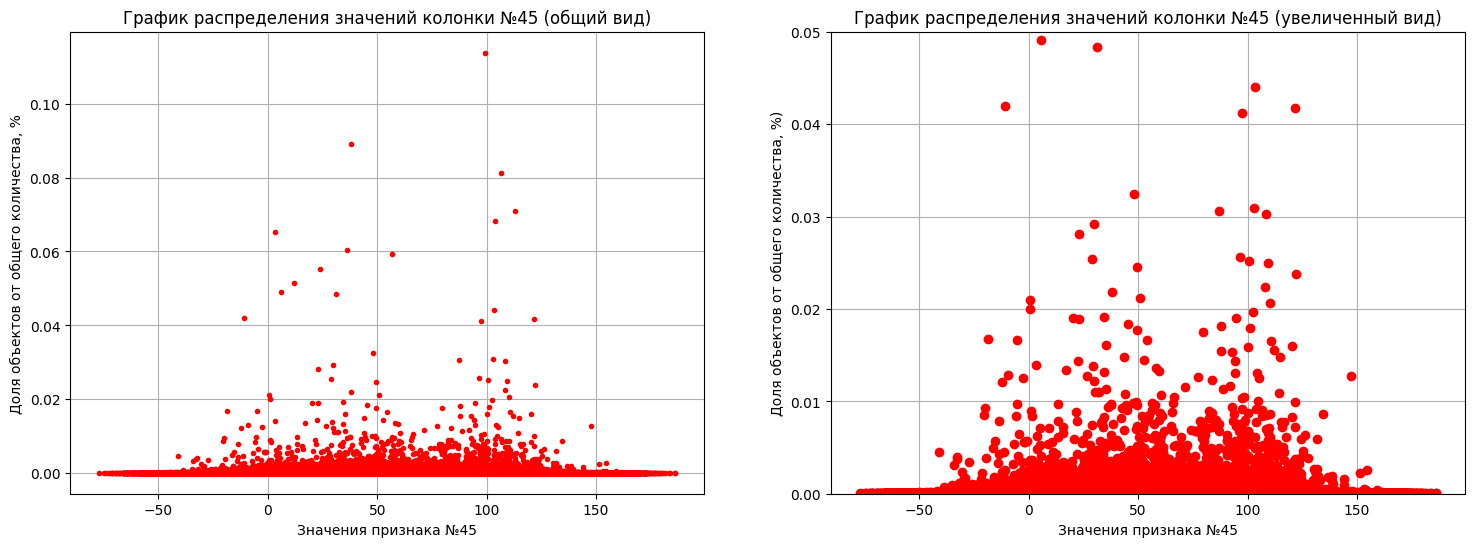

In [101]:
# распределение значений колонки №45
value_analysis(train_df, '45', 0.05, 'red')

Наиболее популярные значения


frequency, %
59                       
-230.403784      0.000069
-13.211805       0.000069
-82.038490       0.000069
-188.534014      0.000069
-651.846315      0.000069

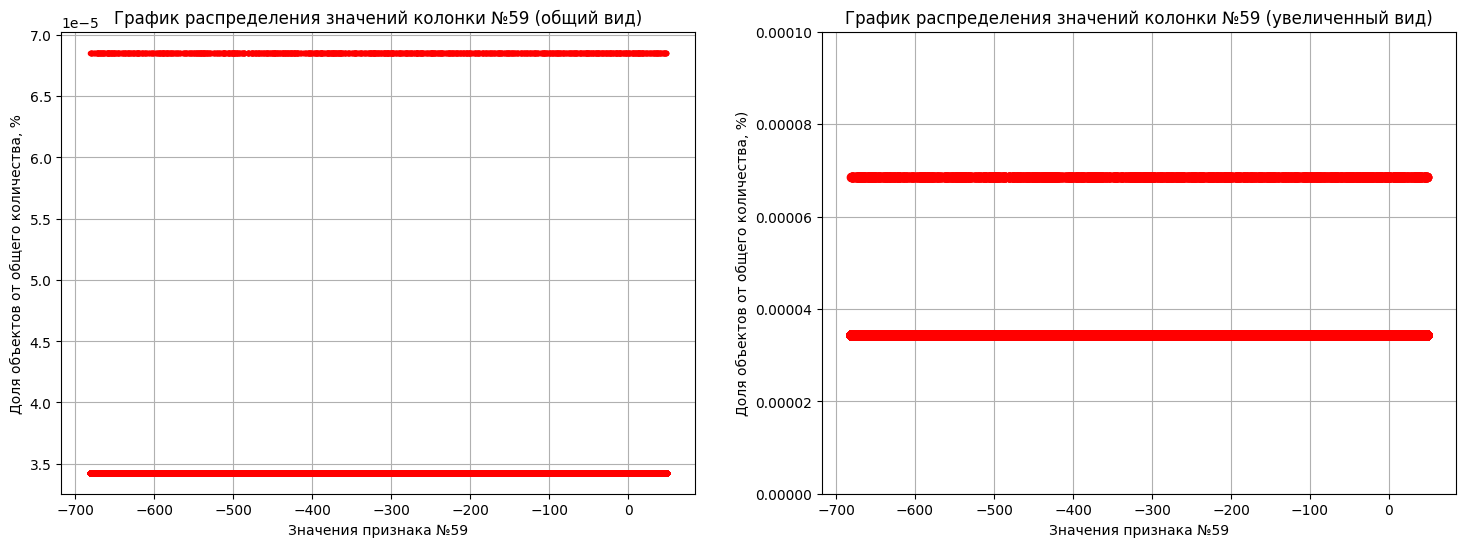

In [102]:
# распределение значений колонки №59
value_analysis(train_df, '59', 0.0001, 'red')

Наиболее популярные значения


frequency, %
65                       
-21.533007       0.113703
 181.959582      0.091085
-81.475771       0.081113
 182.446349      0.070696
 130.450168      0.066207

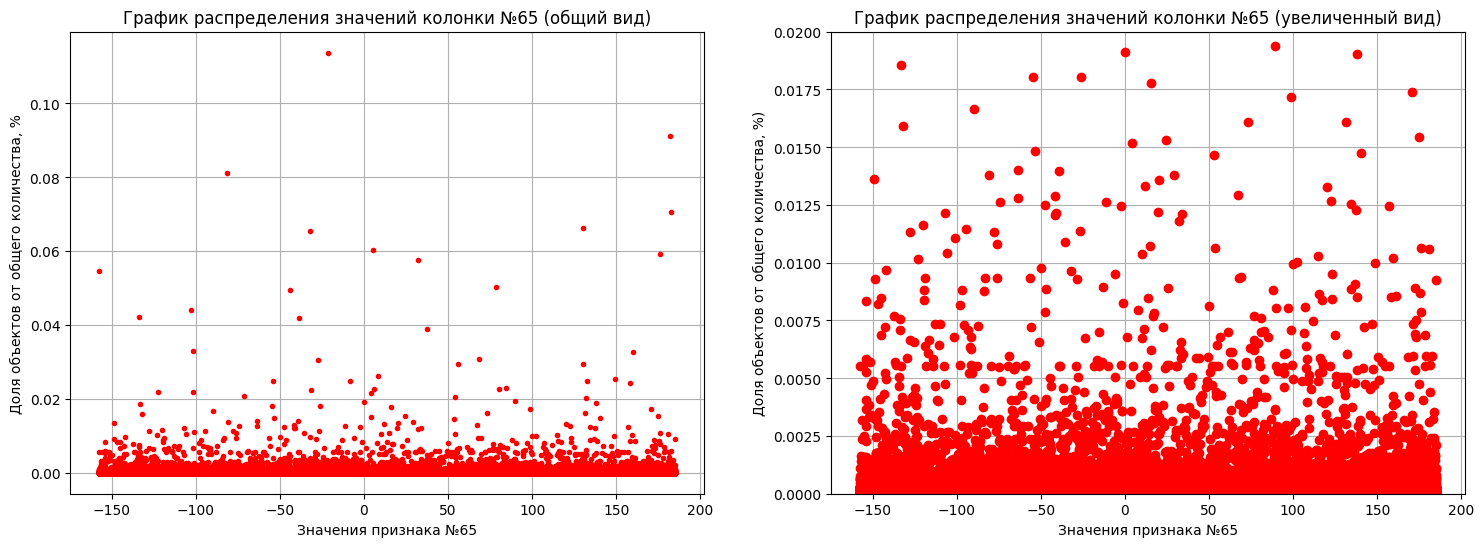

In [103]:
# распределение значений колонки №65
value_analysis(train_df, '65', 0.02, 'red')

Наиболее популярные значения


frequency, %
70                        
-1074.464888     41.923877
-782.676180       0.235321
-597.491204       0.028957
-799.363667       0.005106
-891.219087       0.005072

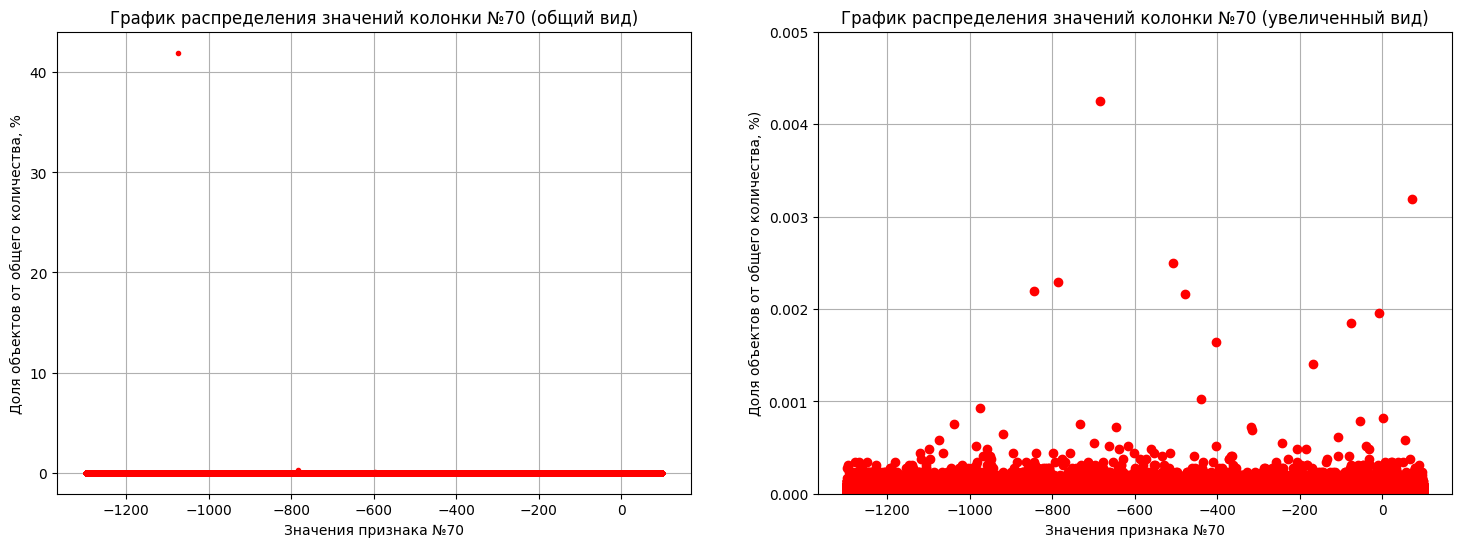

In [104]:
# распределение значений колонки №70
value_analysis(train_df, '70', 0.005, 'red')

### Valid

`Valid` - набор из товаров новых поставок, для которых НЕ известны соответствующие товары и их необходимо найти.

0          1          2          3          4  \
Id                                                                    
100000-query -57.372734   3.597752 -13.213642 -125.92679  110.74594   
100001-query -53.758705  12.790300 -43.268543 -134.41762  114.44991   
100002-query -64.175095  -3.980927  -7.679249 -170.16093   96.44616   
100003-query -99.286860  16.123936   9.837166 -148.06044   83.69708   
100004-query -79.532920  -0.364173 -16.027431 -170.88495  165.45392   

                       5           6           7           8           9  ...  \
Id                                                                        ...   
100000-query  -81.279594 -461.003172  139.815720  112.880980   75.215750  ...   
100001-query  -90.520130 -759.626065   63.995087  127.117905   53.128998  ...   
100002-query  -62.377740 -759.626065   87.477554  131.270110  168.920320  ...   
100003-query -133.729720   58.576403  -19.046660  115.042404   75.206730  ...   
100004-query  -28.291668   33.931936   34.411217  128.903980  102.086914  ...   

                     62         63         64          65        66  \
Id                                                                    
100000-query  -75.51302  52.830902 -143.43945   59.051935  69.28224   
100001-query  -79.44183  29.185436 -168.60590  -82.872443  70.76560   
100002-query -134.79541  37.368730 -159.66231 -119.232725  67.71044   
100003-query  -77.23611  44.100494 -132.53012 -106.318982  70.88396   
100004-query -123.77025  45.635944 -134.25893   13.735359  70.61763   

                     67         68          69           70          71  
Id                                                                       
100000-query  61.927513  111.59253  115.140656 -1099.130485 -117.079360  
100001-query -65.975950   97.07716  123.391640  -744.442332  -25.009320  
100002-query  86.002060  137.63641  141.081630  -294.052271  -70.969604  
100003-query  23.577892  133.18396  143.252940  -799.363667  -89.392670  
100004-query  15.332115  154.56812  101.700640 -1171.892332 -125.307890  

[5 rows x 72 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

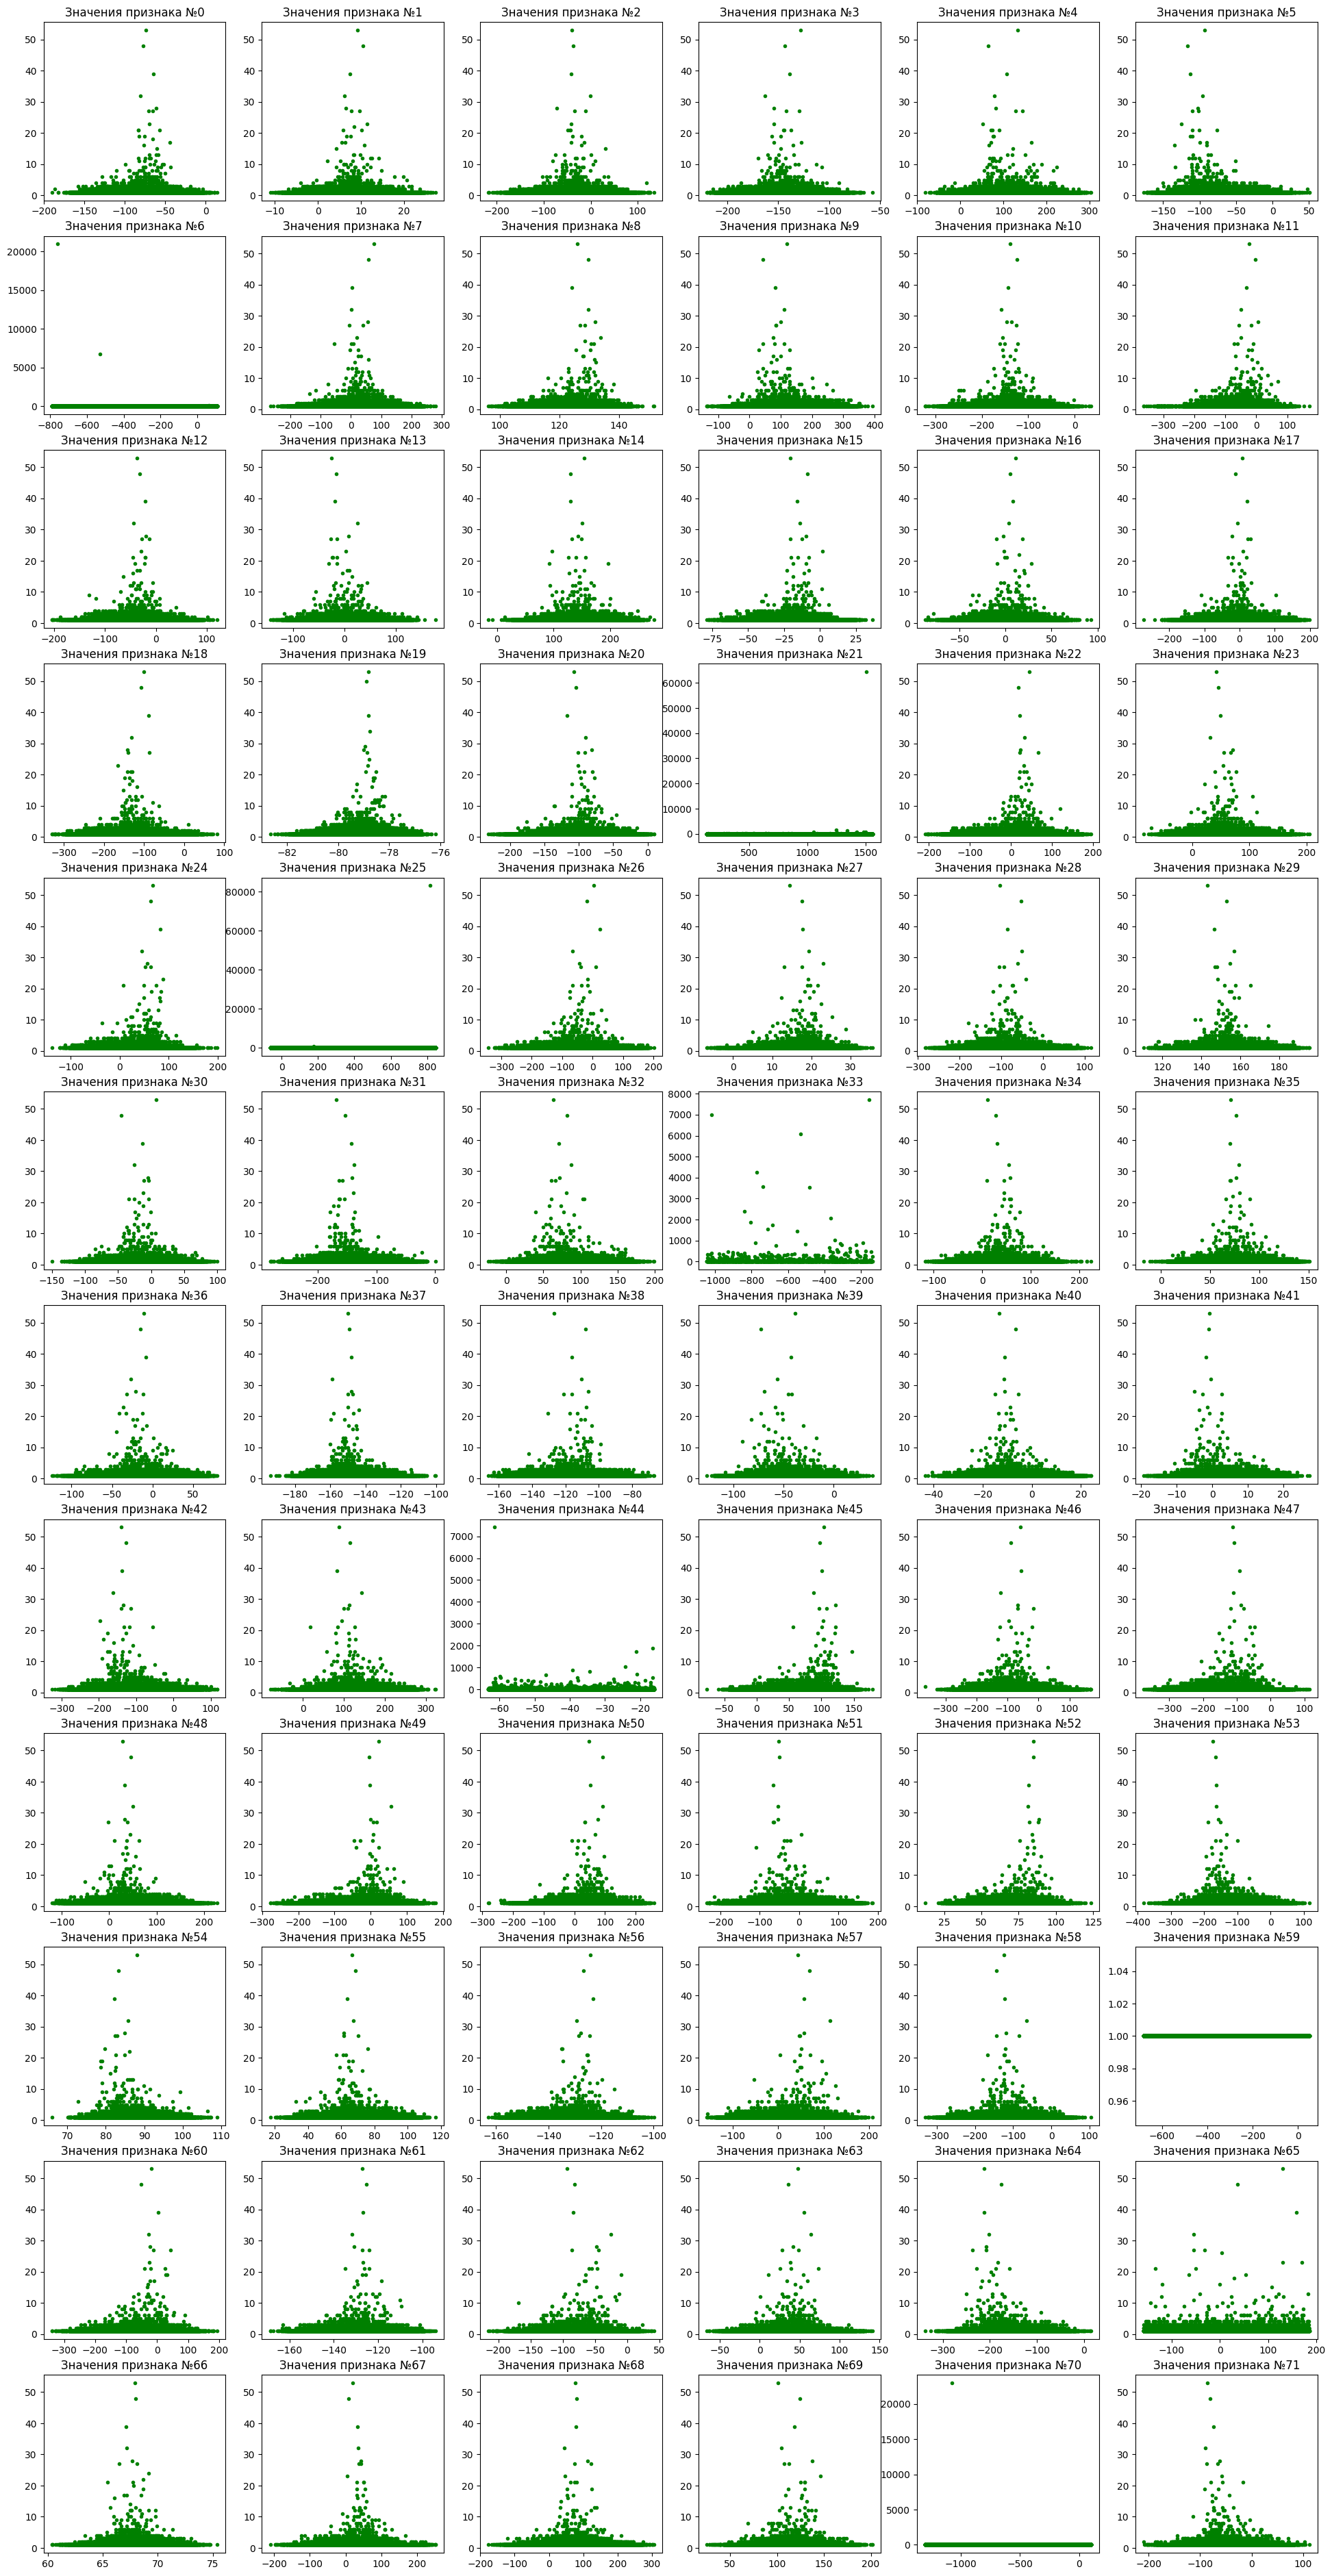

In [105]:
display(valid_df.head())
valid_df.info()
print('Кол-во товаров-дубликатов:', valid_df.duplicated().sum())
show_graph_matrix(valid_df, color='green')

Для того, чтобы не анализировать каждый столбец по отдельности можно воспользоваться функцией `show_general_matrix`. Она позволяет соотнести данные всех датасетов и сравнить на сколько они похожи.

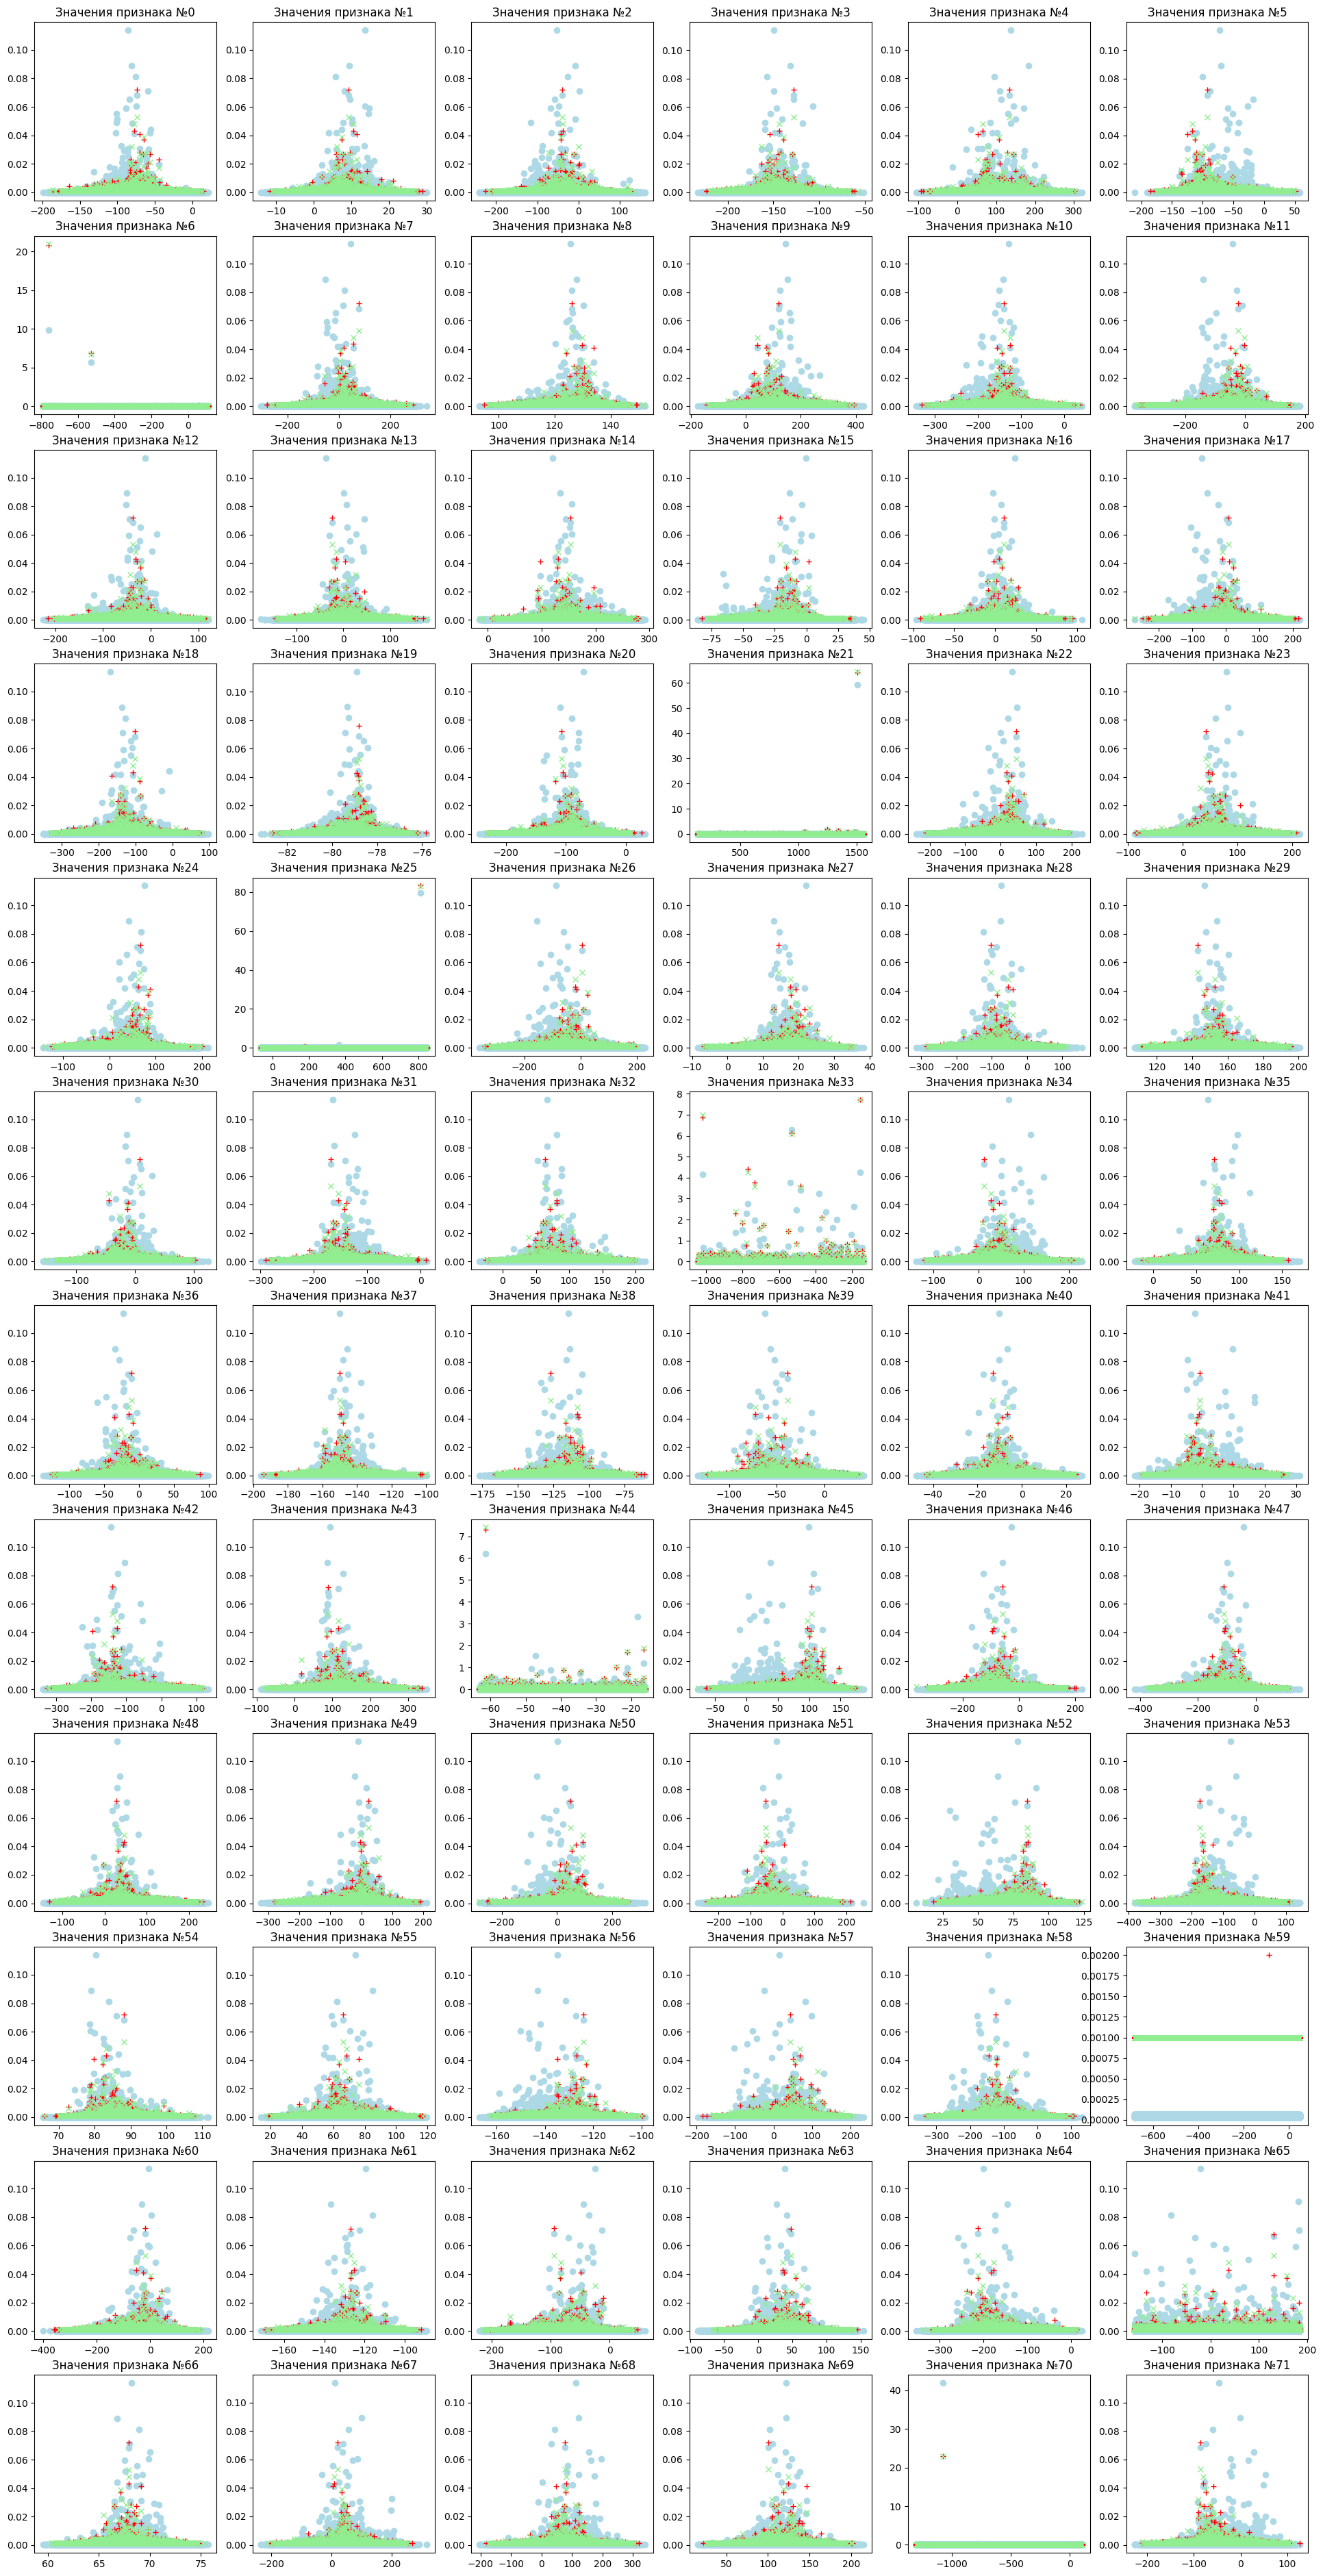

In [106]:
show_general_matrix(base_df, train_df, valid_df)

`Valid_answer` - верные соответствующие товары для выборки Valid. Необходимо для тестирования обученной модели.

In [107]:
display(valid_ans_df.head())
valid_ans_df.info()
print('Кол-во товаров-дубликатов:', valid_ans_df.duplicated().sum())

Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
Кол-во товаров-дубликатов: 8498


**Промежуточный вывод:**

Тип данных - соответствует. Все значения - это числа с плавающий запятов типа `float64`, а id товаров - данные типа `object` или `string`.

Пропуски - отсутствуют.

Выбросы / аномалии - отсутствует. Существует разве что "дисбаланс" между значениями. А именно, некоторые значения встречаются особо часто в сравнении со всеми остальными. К примеру: для признака №25 особо популярен значение 813.770071. Оно встречается у ~80% товаров.

Дубликаты - отсутствуют, за исключением `Valid_answer`. Это может говорить, что одному и тому же "старому" товару, может соответствовать несколько "новых".

Значения признаков сильно отличаются друг от друга. Они могут быть как положительными, так и отрицательными. Могут занимать широкий или узкий числовой диапазон. Для того чтобы каждый признак изначально имел одинаковую значимость необходимо произвести **Масштабирование**.

___

### Масштабирование признаков

На этом этапе данные будут преобразованы из датафрейма в двумерный массив и в результате этого потеряют свои уникальные **id**. Заблаговременно необходимо создать словарь для сопоставления **порядкового номера** вектора (`161948`) и **id** товара (`'161948-base'`).

In [7]:
# словарь id и номеров векторов
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}

print('Пример содержания словаря:\n', list(base_index.items())[0:3])

Пример содержания словаря:
 [(0, '0-base'), (1, '1-base'), (2, '2-base')]


In [11]:
# масштабирование
scaler = StandardScaler()
scaler.fit(base_df)
base_transform  = scaler.transform(base_df)
train_transform = scaler.transform(train_df.drop("Target", axis=1))
valid_transform = scaler.transform(valid_df)

# пример
print('Пример масштабированного вектора из "base":\n',  base_transform[0],  '\n')
print('Пример масштабированного вектора из "train":\n', train_transform[0], '\n')
print('Пример масштабированного вектора из "valid":\n', valid_transform[0], '\n')

Пример масштабированного вектора из "base":
 [-1.15921621  0.62035039 -0.51372266  1.39855776  2.26904345 -1.16038496
 -0.28288362  0.37366256 -0.43562659  0.88454365  0.4576469   0.73073908
 -0.41463426  0.78201584  1.00285473 -0.37510107 -0.20510187  0.33189056
  0.99042818 -0.36617164 -0.2019014   0.62431793 -0.49577625 -0.1530666
 -2.01843422  0.42159108  0.40135749 -1.69555507 -0.89876331 -0.29430765
  0.05313913  0.03532411 -0.26462494  0.06513401 -0.83885471  1.69344411
  0.80234648 -0.67295311 -0.38906162  0.1131067  -0.40123943 -1.40868981
 -0.70640697 -0.96219636 -1.19775652 -1.29778618 -0.22126234  0.00696112
  0.9529048  -2.37308311 -1.29941832  1.57543507  0.84989106  0.52136797
  0.28986782  0.88773797  0.43402009 -1.13324375  0.70881925  1.52490547
  0.00679186 -0.84751261  1.18904887  0.19052392  0.07358854 -0.89478931
 -2.26249347 -0.51043767  0.29300367 -0.0140507   1.78141979 -0.31232868] 

Пример масштабированного вектора из "train":
 [ 1.29951853  1.99688841  0.063

Данные готовы для обработки.

___

##  Поиск ближайших соседей

Принцип работы [Faiss](https://faiss.ai/index.html):
1. Отображение всех объектов (векторов) в едином пространстве
2. Деление полученного пространства на отдельные части (кластеры) при помощи спец. алгоритма библиотеки
3. Для каждого кластера происходит поиск его центра (центроида)
4. Таким образом, для нового вектора можно быстрой найти ближайших соседей, вычислив расстояние именно до центроидов (не перемножая новый вектор со всеми остальными векторами).
5. После выявления ближайшего кластера, новый вектор перемножается векторами только из этого кластера.

`FlatL2` - мера близости вектором L2-норма (евклидово расстояние). По этой причине большое значение имеет "нормализованы ли признаки?", поскольку в этой ситуации признак бóльшей величины будет играть бóльшую роль в предсказании. Но это не отображает достоверность его значимость.

`quantizer` - квантизатор, который получает на вход вектора размерностью `dimensions` и рассчитывает расстояние между ними по евклидовой норме.

`idx_l2` - пространство векторов размерностью `dimensions`, разделяемое на `n_cells` кластеров с помощью `quantizer`.

In [9]:

dimensions = base_df.shape[1] # n-мерность векторов
n_cells = 20 # кол-во кластеров на которые делится всё векторное пространство

quantizer = faiss.IndexFlatL2(dimensions)
idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, n_cells)

Функция `np.ascontiguousarray()` располагает последовательно весь массив данных в оперативной памяти.

In [12]:
# обучение делителя пространства на первых 50 тысячах объектов из df_base
idx_l2.train(np.ascontiguousarray(base_transform[:50000, :]))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform))

Далее следует **процесс поиска** соседей. Дословно строчка кода звучит так: для каждого вектора из `trans_train` найди по **N** ближайших векторов из `df_base` (которые уже размечены на отдельные кластеры). Результатом являются:
- `idx` - порядковые номера ближайших векторов, и
- `vectors` - значения этих векторов.

Этот процесс может быть долгим. Ориентировочное время поиска: 10 - 5 минут (для CPU). Время вычисления сильно зависит от кол-ва кластеров.

In [13]:
top_count = 20 # количество кандидатов на сопоставление
vectors, idx = idx_l2.search(np.ascontiguousarray(train_transform), top_count)

print('Примеры idx :\n', idx[:3], '\n')
print('Примеры vectors :\n', vectors[:3])

Примеры idx :
 [[ 598613  755584  336969 1934845   13374 1136231  480296  583287 2360257
   450667  988777 1653095 1818641  503716 1631947   89840  143978  986050
   629775 2346335]
 [ 737853   15185  519311  223456  464427 2524968  301385  838522  124343
  2162616 1325497  295462 1054077 2296593 1946148  224544  412497 2469267
  2584784    2133]
 [ 173120 1784963 2863071 1143288  955831  137853 1368891  774247 1984148
  1479188 1238526 2351134  641280 1532675 1774212  948608   12304 2395210
  1905367 1341266]] 

Примеры vectors :
 [[19.29954  19.4676   20.747215 23.199968 23.545162 23.618977 26.231094
  26.31761  26.367298 26.42582  26.577133 27.139734 27.454794 27.81587
  28.002184 28.12624  28.746382 28.74659  28.77865  28.836006]
 [22.419256 24.467981 25.589373 30.446188 33.440586 39.883263 42.99969
  57.24867  57.807648 59.229515 59.49543  60.088676 61.019623 61.500263
  62.516914 62.78305  63.010193 63.244263 63.270107 63.369507]
 [18.721733 22.402525 24.452156 24.944101 25.36271

`targets` - список `id` товаров, подходящих по мнению экспертов. (одномерный массив)

`idx` - наборы из top-5 кандидатов на соответствие, предсказанных **МБС** (метод ближайших соседей). Для получения `id` товара, нужно указать числовой индекс в словаре `base_index`. 

In [14]:
# выделение цел. признака в отдельный датасет
targets = train_df['Target']

acc = 0
for target, candidates in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[number] for number in candidates])

print('accuracy@20: {}%'.format(acc / len(idx) * 100))

accuracy@20: 61.758%


На этом этапе получилось найти top-5 кандидатов для сопоставления. Теперь среди них необходимо выявить самый подходящий. Для этого всех кандидатов необходимо отранжировать.

## Ранжирование

Первым делом необходимо составить новый датафрейм состоящий из двух половин:
1. Искомые векторы
2. Несколько кандидатов на сопоставление для каждого искомого вектора.

Последним столбцом для этого вектора станет `Target` содержащий правильный ответ: 1 - вектор подходит, 0 - вектор не подходим.

In [20]:
# подготовка датафрейма с перечнем ID новых и старых объектов
idx_df = pd.DataFrame(data=idx, index=train_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['Id_train', 'candidates']
idx_df['Id_base'] = [base_index[number] for number in idx_df['candidates'].values]
idx_df.drop('candidates', axis=1, inplace=True)

display(idx_df)

Id_train       Id_base
0            0-query   675816-base
1            0-query   877519-base
2            0-query   361564-base
3            0-query  2725256-base
4            0-query    13406-base
...              ...           ...
1999995  99999-query   586430-base
1999996  99999-query    10146-base
1999997  99999-query  3193924-base
1999998  99999-query  3477610-base
1999999  99999-query   762477-base

[2000000 rows x 2 columns]

In [22]:
# объединение base и train по списку ближайших соседей (ver. 3)
base_train_df = idx_df.merge(base_df, left_on='Id_base', right_on='Id', how='left')
base_train_df = base_train_df.merge(train_df, left_on='Id_train', right_on='Id', suffixes=('_base', '_train'), how='left')
display(base_train_df)

Id_train       Id_base     0_base     1_base     2_base  \
0            0-query   675816-base -63.856552  17.163416 -32.269220   
1            0-query   877519-base -57.214447  19.121440 -71.790430   
2            0-query   361564-base -60.221460  17.415554 -44.884090   
3            0-query  2725256-base -57.044890  17.853909 -54.989470   
4            0-query    13406-base -57.223480  19.974297 -53.375565   
...              ...           ...        ...        ...        ...   
1999995  99999-query   586430-base -41.625916  11.788382 -37.313900   
1999996  99999-query    10146-base -65.103870  13.204195 -30.182644   
1999997  99999-query  3193924-base -64.349410  11.611373 -14.881422   
1999998  99999-query  3477610-base -66.452270  13.731966 -46.986130   
1999999  99999-query   762477-base -83.397490   7.251070 -62.056800   

            3_base     4_base     5_base      6_base     7_base  ...  \
0       -169.75210  198.87073 -77.228960 -347.360606  13.288679  ...   
1       -181.06204  199.41292 -76.055595 -574.935001  29.120632  ...   
2       -187.29471  177.27692 -79.936890 -759.626065  50.207900  ...   
3       -178.70386  161.50366 -87.388510 -362.937755  15.136107  ...   
4       -186.22748  184.98380 -70.802500 -728.416990  54.787804  ...   
...            ...        ...        ...         ...        ...  ...   
1999995 -165.10168  102.63001 -77.978210 -503.329925   8.619784  ...   
1999996 -145.29507  148.41060 -85.447300 -705.486862  33.453506  ...   
1999997 -149.72475  121.86004 -79.253790  -33.723216  23.971900  ...   
1999998 -137.22081  153.51802 -81.202330   55.592120 -42.629380  ...   
1999999 -157.22256   88.35747 -53.218525  -99.980666  37.692738  ...   

          63_train   64_train    65_train  66_train   67_train    68_train  \
0        70.107360 -155.80257 -101.965943  65.90379  34.457500   62.642094   
1        70.107360 -155.80257 -101.965943  65.90379  34.457500   62.642094   
2        70.107360 -155.80257 -101.965943  65.90379  34.457500   62.642094   
3        70.107360 -155.80257 -101.965943  65.90379  34.457500   62.642094   
4        70.107360 -155.80257 -101.965943  65.90379  34.457500   62.642094   
...            ...        ...         ...       ...        ...         ...   
1999995   5.184549 -134.78845  -78.863722  66.88463  45.619125  129.991240   
1999996   5.184549 -134.78845  -78.863722  66.88463  45.619125  129.991240   
1999997   5.184549 -134.78845  -78.863722  66.88463  45.619125  129.991240   
1999998   5.184549 -134.78845  -78.863722  66.88463  45.619125  129.991240   
1999999   5.184549 -134.78845  -78.863722  66.88463  45.619125  129.991240   

          69_train    70_train   71_train        Target  
0        134.76360 -415.750254 -25.958572   675816-base  
1        134.76360 -415.750254 -25.958572   675816-base  
2        134.76360 -415.750254 -25.958572   675816-base  
3        134.76360 -415.750254 -25.958572   675816-base  
4        134.76360 -415.750254 -25.958572   675816-base  
...            ...         ...        ...           ...  
1999995  100.65671  -43.558286 -80.152910  2769109-base  
1999996  100.65671  -43.558286 -80.152910  2769109-base  
1999997  100.65671  -43.558286 -80.152910  2769109-base  
1999998  100.65671  -43.558286 -80.152910  2769109-base  
1999999  100.65671  -43.558286 -80.152910  2769109-base  

[2000000 rows x 147 columns]

In [31]:
# объединение base и train по списку ближайших соседей (ver. 4)
train_base_df = idx_df.merge(train_df, left_on='Id_train', right_on='Id', how='left')
train_base_df = train_base_df.merge(base_df, left_on='Id_base', right_on='Id', how='left', suffixes=('_train', '_base'))
train_base_df['Target'] = train_base_df['Id_base'] == train_base_df['Target']

display(train_base_df[['Id_train', 'Id_base', 'Target']])

Id_train       Id_base  Target
0            0-query   675816-base    True
1            0-query   877519-base   False
2            0-query   361564-base   False
3            0-query  2725256-base   False
4            0-query    13406-base   False
...              ...           ...     ...
1999995  99999-query   586430-base   False
1999996  99999-query    10146-base   False
1999997  99999-query  3193924-base   False
1999998  99999-query  3477610-base   False
1999999  99999-query   762477-base   False

[2000000 rows x 3 columns]

## Вывод

**Возможные улучшения**
1. В поиске ближайших соседей в качестве мера близости использовать [другие варианты](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes), к примеру: `IndexFlatIP` или `IndexIVFPQ`